In [1]:
import warnings
warnings.filterwarnings('ignore')
import os
import awkward as ak
import uproot
import hist
import numpy as np
from coffea import processor
from coffea.nanoevents import NanoEventsFactory, NanoAODSchema, BaseSchema
from coffea.processor import dict_accumulator, list_accumulator

import matplotlib.pyplot as plt
import matplotlib.colors as colors
import mplhep as hep
plt.style.use(hep.style.ROOT)

import matplotlib.pylab as pylab
params = {'legend.fontsize': 'medium',
         'axes.labelsize': 'x-large',
         'axes.titlesize':'x-large',
         'xtick.labelsize':'medium',
         'ytick.labelsize':'medium'}
pylab.rcParams.update(params)

#line thickness
import matplotlib as mpl
mpl.rcParams['lines.linewidth'] = 5
import itertools
import json

# for making fancy 2d histograms
import plotly.graph_objects as go
from plotly.subplots import make_subplots

from utils import (plot_1d_trigger_efficiencies, 
                plot_1d_trigger_efficiencies_improvement, 
                plot_fancy_2d_trigger_efficiencies, 
                compare_trigger_efficiencies, 
                plot_1d_trigger_soup_compact,
                plot_1d_trigger_soup_cms)
from trig_eff_process import (create_baseline_selection_mask, 
                            TriggerEfficiencyProcessor, 
                            TriggerEfficiencyImprovementProcessor, 
                            VBFBaselineCutFlowProcessor, 
                            GeneralBaselineCutFlowProcessor,
                            TriggerSoupProcessor,
                            TriggerSoupProcessor_individual)

In [2]:
def create_baseline_selection_mask_new(events, tag):
    n_events = len(events)
    # Start with all events selected.
    baseline_mask = np.ones(n_events, dtype=bool)
    
    # ------------------------------------------------------------------
    # Step 1: Common jet selection, e.g. require at least one AK4 jet with pt > 15 GeV.
    jets_all = events.Jet[events.Jet.pt > 15]
    has_jets = ak.num(jets_all) >= 1
    baseline_mask &= ak.to_numpy(has_jets)
    
    # ------------------------------------------------------------------
    # Step 2: General selection on FatJets.
    # Select events that have at least one FatJet satisfying:
    #   - pt > 250,
    #   - |eta| < 2.5, and
    #   - particleNet_XbbVsQCD > 0.4.
    fatjets = events.FatJet
    fatjet_mask = (fatjets.pt > 250) & (abs(fatjets.eta) < 2.5) & (fatjets.particleNet_XbbVsQCD > 0.4)
    has_fatjet = ak.sum(fatjet_mask, axis=1) >= 1
    baseline_mask &= ak.to_numpy(has_fatjet)
    
    # ------------------------------------------------------------------
    # Step 3: If tag is "VBF", apply additional VBF selection on top of general selection.
    if tag == "VBF":
        # Select additional jets (AK4) with:
        #   - pt > 15 GeV (common threshold) and
        #   - |eta| < 5.0.
        jets = events.Jet
        jets = jets[
            (jets.pt > 30.)
            & (abs(jets.eta) < 5.0)
            & jets.isTight
        ]

        # only consider first 4 jets to be consistent with old framework
        jets = jets[:, :4]
        
        # Require at least two such jets per event.
        has_two_jets = ak.num(jets) >= 2
        
        # VBF specific variables                                                      
        dR = jets.delta_r(candidatejet)
        ak4_outside_ak8 = jets[dR > 0.8]

        jet1 = ak4_outside_ak8[:, 0:1]
        jet2 = ak4_outside_ak8[:, 1:2]

        deta = abs(ak.firsts(jet1).eta - ak.firsts(jet2).eta)
        mjj = ( ak.firsts(jet1) + ak.firsts(jet2) ).mass

        has_valid_pair = ((deta > 3.5) & (mjj > 1000))
        
        # # Form all combinations of two jets in each event.
        # jet_pairs = ak.combinations(additional_jets, 2, fields=["jet1", "jet2"])
        # # Calculate the absolute difference in eta (rapidity separation) of the two jets.
        # delta_eta = abs(jet_pairs.jet1.eta - jet_pairs.jet2.eta)
        # # Calculate the dijet invariant mass for the jet pair.
        # mjj = (jet_pairs.jet1 + jet_pairs.jet2).mass
        # # VBF criteria: at least one pair must satisfy:
        # #   - |delta_eta| > 3.5, and
        # #   - mjj > 1000 GeV.
        # has_valid_pair = ak.any((deta > 3.5) & (mjj > 1000), axis=1)
        
        # Combine the VBF-specific requirements.
        vbf_mask = has_two_jets & has_valid_pair
        
        # Update the cumulative baseline mask.
        baseline_mask &= ak.to_numpy(vbf_mask)
    
    # Final sanity check: baseline_mask length must equal the number of original events.
    assert len(baseline_mask) == n_events, "Baseline mask length does not match number of events!"
    
    return baseline_mask

In [3]:
import numpy as np
import awkward as ak
from coffea import processor  # assuming you are using coffea
from coffea.processor import dict_accumulator, list_accumulator

class GeneralBaselineCutFlowProcessor(processor.ProcessorABC):
    def __init__(self):
        # Initialize the output accumulator
        self.output = dict_accumulator({
            'cutflow': dict_accumulator(),
            # Include other outputs if needed
        })

    def process(self, events):
        output = self.output
        cutflow = output['cutflow']

        # Total number of events before any cuts
        n_events = len(events)
        cutflow['All events'] = cutflow.get('All events', 0) + n_events

        ### Start of the selection steps ###
        # Initialize cumulative event mask (as an Awkward Array)
        cumulative_event_mask = ak.from_numpy(np.ones(n_events, dtype=bool))

        # ------------------------------------------------------------------
        # Step 1: Common selection: require at least one AK4 jet with pt > 15 GeV.
        jets_all = events.Jet[events.Jet.pt > 15]
        has_jets = ak.num(jets_all) >= 1
        cumulative_event_mask = cumulative_event_mask & has_jets

        n_events_has_jets = int(ak.sum(cumulative_event_mask))
        cutflow['AK4 pt > 15'] = \
            cutflow.get('AK4 pt > 15', 0) + n_events_has_jets

        # ------------------------------------------------------------------
        # Step 2: General selection on FatJets.
        # Require at least one FatJet with:
        #   - pt > 250,
        #   - |eta| < 2.5, and
        #   - particleNet_XbbVsQCD > 0.4.
        fatjets = events.FatJet
        fatjet_mask = (fatjets.pt > 250) & (abs(fatjets.eta) < 2.5) & (fatjets.particleNet_XbbVsQCD > 0.4)
        has_fatjet = ak.sum(fatjet_mask, axis=1) >= 1
        cumulative_event_mask = cumulative_event_mask & has_fatjet

        n_events_has_fatjet = int(ak.sum(cumulative_event_mask))
        cutflow['FatJet'] = (
            cutflow.get('FatJet', 0)
            + n_events_has_fatjet
        )

        # ------------------------------------------------------------------
        # --- VBF-specific selection ---
        # Select additional AK4 jets with:
        #   - pt > 30 GeV,
        #   - |eta| < 5.0, and
        #   - passing tight identification (isTight).
        jets = events.Jet[(events.Jet.pt > 30) &
                          (abs(events.Jet.eta) < 5.0) &
                          (events.Jet.isTight)]
        # Only consider the first 4 jets per event (to be consistent with the old framework)
        jets = jets[:, :4]

        # Require at least two such jets per event.
        has_two_jets = ak.num(jets) >= 2

        # Define the candidate fatjet using the FatJet selection from Step 2.
        # Here we take the first FatJet that passes our fatjet_mask.
        candidatejet = ak.firsts(events.FatJet[fatjet_mask])

        # Compute ΔR between the selected jets and the candidate fatjet.
        dR = jets.delta_r(candidatejet)
        # Exclude jets overlapping with the candidate fatjet by requiring dR > 0.8.
        ak4_outside_ak8 = jets[dR > 0.8]

        # For VBF variables we only consider the first two non-overlapping jets.
        jet1 = ak4_outside_ak8[:, 0:1]
        jet2 = ak4_outside_ak8[:, 1:2]

        # For events where fewer than two jets remain after the ΔR cut,
        # the following operations will yield None values.
        # So, require that at least two jets remain.
        has_two_jets_after_dr = ak.num(ak4_outside_ak8) >= 2

        # Compute rapidity separation (deta) and dijet invariant mass (mjj)
        deta = abs(ak.firsts(jet1).eta - ak.firsts(jet2).eta)
        mjj = (ak.firsts(jet1) + ak.firsts(jet2)).mass

        # VBF criteria: require deta > 3.5 and mjj > 1000 GeV.
        has_valid_pair = (deta > 3.5) & (mjj > 1000)

        # Combine the VBF-specific requirements.
        vbf_mask = has_two_jets & has_two_jets_after_dr & has_valid_pair

        cumulative_event_mask = cumulative_event_mask & ak.to_numpy(vbf_mask)
        n_events_vbf = int(ak.sum(cumulative_event_mask))
        cutflow['VBF selection '] = (
            cutflow.get('VBF selection', 0)
            + n_events_vbf
        )

        # Note: No filtering is performed on events/objects throughout these steps to maintain consistent shapes.

        # Optionally, you can store the cumulative mask in the output if needed.
        # output['cumulative_event_mask'] = cumulative_event_mask

        return output

    def postprocess(self, accumulator):
        # No postprocessing required in this example.
        return accumulator


In [4]:
import os
import numpy as np
import matplotlib.pyplot as plt
import mplhep as hep

def plot_cutflow(output, save_dir, year, small_font_size=12):
    """
    Creates and saves a CMS-style cutflow diagram from the provided output dictionary,
    displaying the number of events passing each selection step on top of the bars.

    Parameters:
    output (dict): A dictionary containing a 'cutflow' key with selection names and event counts.
    save_dir (str): The directory where the plot will be saved.
    year (int): The data-taking year (for the CMS label).
    small_font_size (int, optional): Font size for labels and title. Default is 12.
    """
    # Access the cutflow dictionary and print the counts
    cutflow = output['cutflow']
    for cut, count in cutflow.items():
        print(f"{cut}: {count}")

    # Prepare data for plotting
    cuts = list(cutflow.keys())
    counts = [cutflow[cut] for cut in cuts]

    # Update global font size for CMS-style plots
    plt.rcParams.update({"font.size": small_font_size})

    # Create figure and CMS style axis
    fig, ax = plt.subplots(figsize=(10, 6))
    ax.set_yscale("log")
    
    # Plot the bars with a CMS-inspired color scheme and edge color
    bars = ax.bar(cuts, counts, color='C1', edgecolor='black', linewidth=1)
    
    # Add event count labels on top of each bar
    ax.bar_label(bars, labels=[str(count) for count in counts], padding=3, fontsize=small_font_size)
    
    # Set axes labels and title
    ax.set_xlabel("Selection Steps", fontsize=small_font_size)
    ax.set_ylabel("Number of Events", fontsize=small_font_size)
    ax.set_title("Cutflow Diagram", fontsize=small_font_size)
    
    # Rotate x-tick labels for readability and set tick label sizes
    plt.xticks(rotation=45, fontsize=small_font_size)
    plt.yticks(fontsize=small_font_size)
    
    # Add grid on the y-axis
    ax.grid(axis='y')
    
    # Add CMS label (see reference: plot_1d_trigger_soup_cms)
    hep.cms.label(ax=ax, data=False, year=year, com="Preliminary")
    
    plt.tight_layout()
    
    # Ensure save directory exists and then save the figure
    os.makedirs(save_dir, exist_ok=True)
    fig_path = os.path.join(save_dir, "cutFlow_cms.png")
    plt.savefig(fig_path, bbox_inches='tight', dpi=300)
    plt.show()
    plt.close(fig)


In [5]:
trig_vars = {
    'ht': {
        'label': "H_{T} [GeV]",
        'axis': hist.axis.Regular(bins=100, start=0, stop=2000, name="ht", label="H_{T} [GeV]"),
        'proc': lambda events: ak.sum(events.FatJet.pt, axis=1)
    },
    'pt': {
        'label': "Leading Jet $p_{T}$ [GeV]",
        'axis': hist.axis.Regular(bins=30, start=0, stop=1200, name="pt", label="Leading Jet $p_{T}$ [GeV]"),
        'proc': lambda events: ak.fill_none(ak.pad_none(events.FatJet.pt, 1, clip=True)[:, 0], np.nan)
    },
    'msd': {
        'label': "Leading Jet $m_{SD}$ [GeV]",
        'axis': hist.axis.Regular(bins=10, start=40, stop=200, name="msd", label="Leading Jet $m_{SD}$ [GeV]"),
        'proc': lambda events: ak.fill_none(ak.pad_none(events.FatJet.msoftdrop, 1, clip=True)[:, 0], np.nan)
    },
    'num_ak4': {
        'label': "Number of AK4 Jets",
        'axis': hist.axis.Integer(0, 20, name="num_ak4", label="Number of AK4 Jets"),
        'proc': lambda events: ak.num(events.Jet)
    },
    'gen_H_pt': {
        'label': "Gen Higgs pT [GeV]",
        'axis': hist.axis.Regular(bins=30, start=0, stop=1200, name="gen_H_pt", label="Gen Higgs pT [GeV]"),
        'proc': lambda events: events.HTXS.Higgs_pt
    },
    'particleNet_XbbVsQCD':{
        'label': "Leading Particle Net TXbb score",
        'axis': hist.axis.Regular(bins=30, start=0, stop=1, name="particleNet_XbbVsQCD", label="Leading Particle Net TXbb score"),
        'proc': lambda events: ak.fill_none(
            ak.pad_none(events.FatJet.particleNet_XbbVsQCD, 1, clip=True)[:, 0],
            np.nan
        )
    }
}


In [6]:
from coffea import nanoevents
events = nanoevents.NanoEventsFactory.from_root(
    "root://cmseos.fnal.gov//store/user/lpcdihiggsboost/NanoAOD_v12_ParT/rkansal/2022/HHbbtt/GluGlutoHHto2B2Tau_kl-1p00_kt-1p00_c2-0p00_LHEweights_TuneCP5_13p6TeV_powheg-pythia8/GluGlutoHHto2B2Tau_kl-1p00_kt-1p00_c2-0p00_TuneCP5_13p6TeV/241028_235514/0000/Run3Summer22NanoAODv12_1-1.root",
    schemaclass=nanoevents.NanoAODSchema,
).events()

In [7]:
events.FatJet.particleNet_XbbVsQCD

<Array [[], [], [], ... [0.986, -10], []] type='25300 * var * float32[parameters...'>

In [8]:
class ParkingSoupProcessor(processor.ProcessorABC):
    """
    Calculate histograms for three scenarios:
      1) Baseline (no triggers)
      2) Orig + 4Quad triggers combined
      3) Orig + PNetQuad trigger only
    """
    def __init__(self, orig_trig_soup, parking_trig_soup, trig_vars, group_1_tag, group_2_tag, baseline_key='VBF'):
        self.orig_trig_soup = orig_trig_soup
        self.parking_trig_soup = parking_trig_soup
        self.trig_vars = trig_vars
        self.baseline_key = baseline_key
        self.group_1_tag = group_1_tag
        self.group_2_tag = group_2_tag

        # Prepare the accumulators for output
        # We'll store:
        #  - "Baseline" as a list accumulator (no 'pass' sub-key, because it's just total baseline distribution)
        #  - "Orig+Parking" has sub-key 'pass'
        #  - "Orig" has sub-key 'pass'
        self.output = dict_accumulator({
            'Baseline': dict_accumulator({
                var_name: list_accumulator() for var_name in trig_vars
            }),
            group_1_tag: dict_accumulator({
                var_name: dict_accumulator({'pass': list_accumulator()})
                for var_name in trig_vars
            }),
            group_2_tag: dict_accumulator({
                var_name: dict_accumulator({'pass': list_accumulator()})
                for var_name in trig_vars
            }),
        })

    def process(self, events):
        output = self.output

        # 1) Compute baseline mask
        baseline_mask = create_baseline_selection_mask_new(events, tag=self.baseline_key)

        # 2) Compute variable arrays (and a valid-vars mask)
        variables = {}
        for var_name, var_info in self.trig_vars.items():
            # var_info['proc'] should be a callable that computes the variable array
            var_array = var_info['proc'](events)
            variables[var_name] = var_array

        valid_vars_mask = np.ones(len(events), dtype=bool)
        for var_array in variables.values():
            # convert to numpy to check NaNs
            valid_vars_mask &= ~np.isnan(ak.to_numpy(var_array))

        # 3) The "baseline" selection = baseline_mask & valid_vars_mask
        selection_baseline = baseline_mask & valid_vars_mask

        #    Fill "Baseline" histograms (no trigger requirement)
        for var_name in self.trig_vars:
            var_array = variables[var_name]
            var_total = var_array[selection_baseline]
            output['Baseline'][var_name].extend(ak.to_numpy(var_total).tolist())

        # 4) Build combined trigger masks:
        #    -- orig triggers
        if len(self.orig_trig_soup) > 0:
            combined_orig_mask = ak.zeros_like(events.HLT[self.orig_trig_soup[0]], dtype=bool)
            for trig in self.orig_trig_soup:
                combined_orig_mask = combined_orig_mask | events.HLT[trig]
        else:
            # If no orig triggers provided, mask is all False
            combined_orig_mask = ak.zeros_like(baseline_mask, dtype=bool)

        #    -- parking triggers
        if len(self.parking_trig_soup) > 0:
            combined_parking_mask = ak.zeros_like(events.HLT[self.parking_trig_soup[0]], dtype=bool)
            for trig in self.parking_trig_soup:
                combined_parking_mask = combined_parking_mask | events.HLT[trig]
        else:
            # If no parking triggers provided, mask is all False
            combined_parking_mask = ak.zeros_like(baseline_mask, dtype=bool)

        #    -- orig+parking combined (logical OR)
        combined_orig_plus_parking_mask = combined_orig_mask | combined_parking_mask

        # 5) Form the final pass selections (baseline & triggers & valid_vars)
        selection_pass_orig = baseline_mask & combined_orig_mask & valid_vars_mask
        selection_pass_orig_plus_parking = baseline_mask & combined_orig_plus_parking_mask & valid_vars_mask

        # 6) Fill histograms: "Orig" and "OrigPlusParking"
        for var_name in self.trig_vars:
            var_array = variables[var_name]

            # Orig
            var_pass_orig = var_array[selection_pass_orig]
            output[self.group_1_tag][var_name]['pass'].extend(ak.to_numpy(var_pass_orig).tolist())

            # Orig + Parking
            var_pass_orig_plus_parking = var_array[selection_pass_orig_plus_parking]
            output[self.group_2_tag][var_name]['pass'].extend(ak.to_numpy(var_pass_orig_plus_parking).tolist())

        return output

    def postprocess(self, accumulator):
        return accumulator


Processing period 2022
Currently processing production mode VBF


Output()

Output()

All events: 2640980
AK4 pt > 15: 2638812
FatJet: 39220
VBF selection : 14017


Currently processing production mode ggF


Output()

Output()

All events: 107704
AK4 pt > 15: 107704
FatJet: 25909
VBF selection : 1000


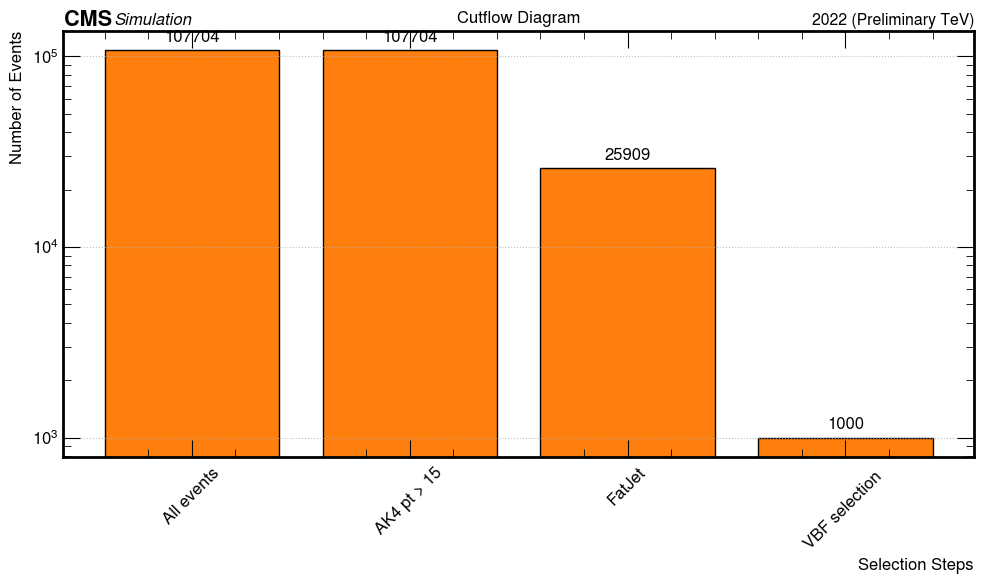

Processing period 2022EE
Currently processing production mode VBF


Output()

Output()

All events: 4383505
AK4 pt > 15: 4379247
FatJet: 64974
VBF selection : 22620


Currently processing production mode ggF


Output()

Output()

All events: 857417
AK4 pt > 15: 857416
FatJet: 207091
VBF selection : 8024


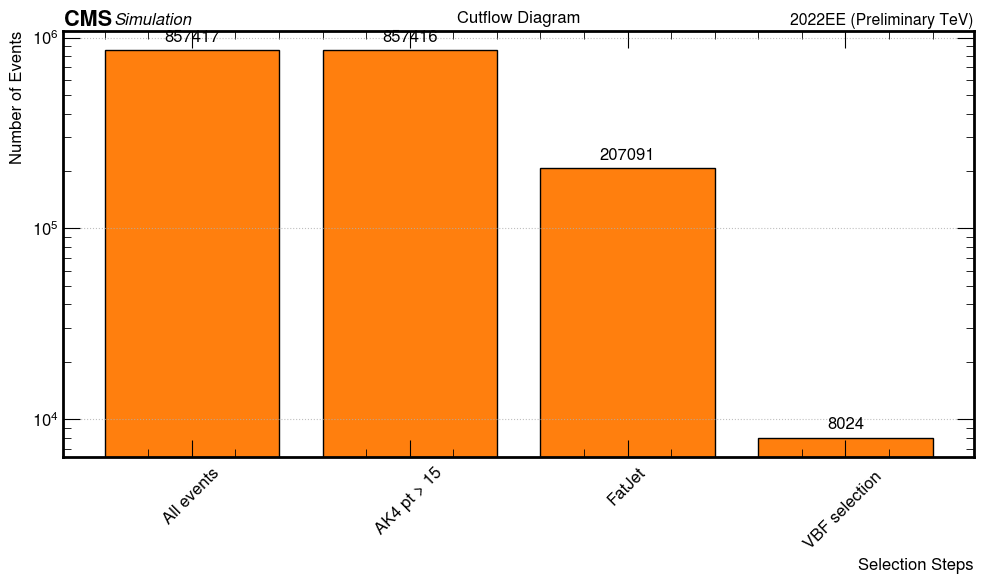

Processing period 2023
Currently processing production mode VBF


Output()

Output()

All events: 6633600
AK4 pt > 15: 6627605
FatJet: 90316
VBF selection : 32282


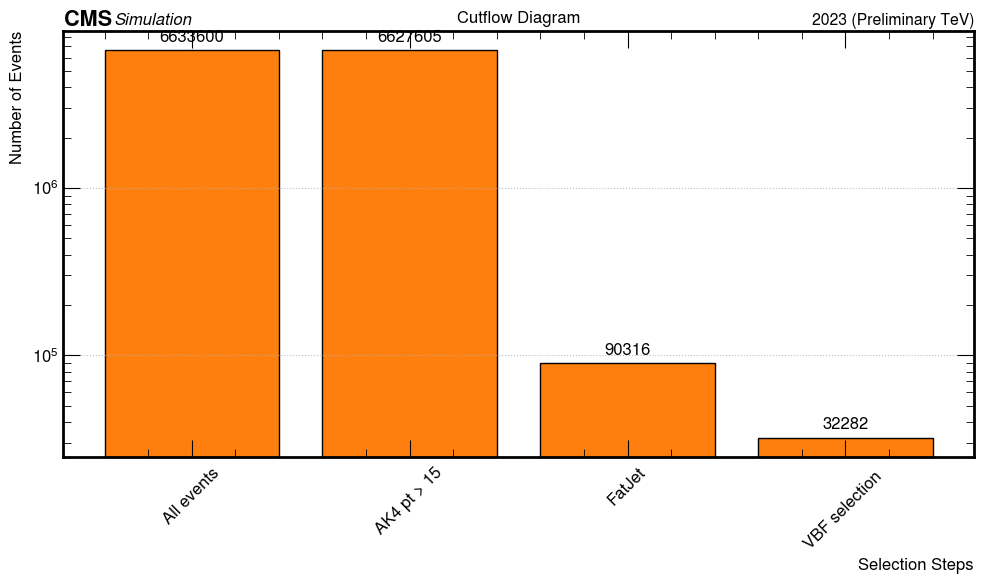

Currently processing production mode ggF


Output()

Output()

All events: 1654529
AK4 pt > 15: 1654526
FatJet: 365441
VBF selection : 15114


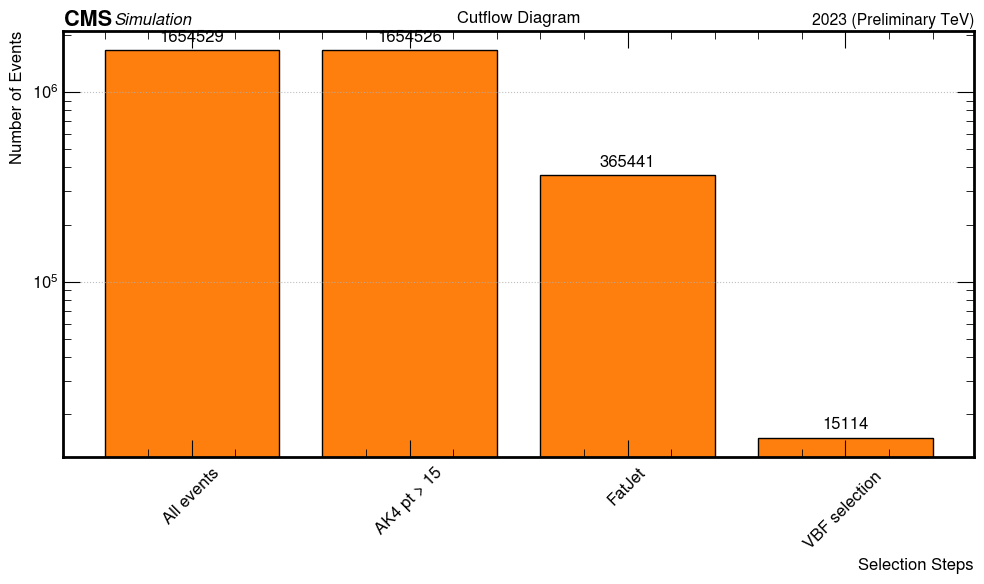

Processing period 2023BPix
Currently processing production mode VBF


Output()

Output()

All events: 5582000
AK4 pt > 15: 5576926
FatJet: 75684
VBF selection : 27171


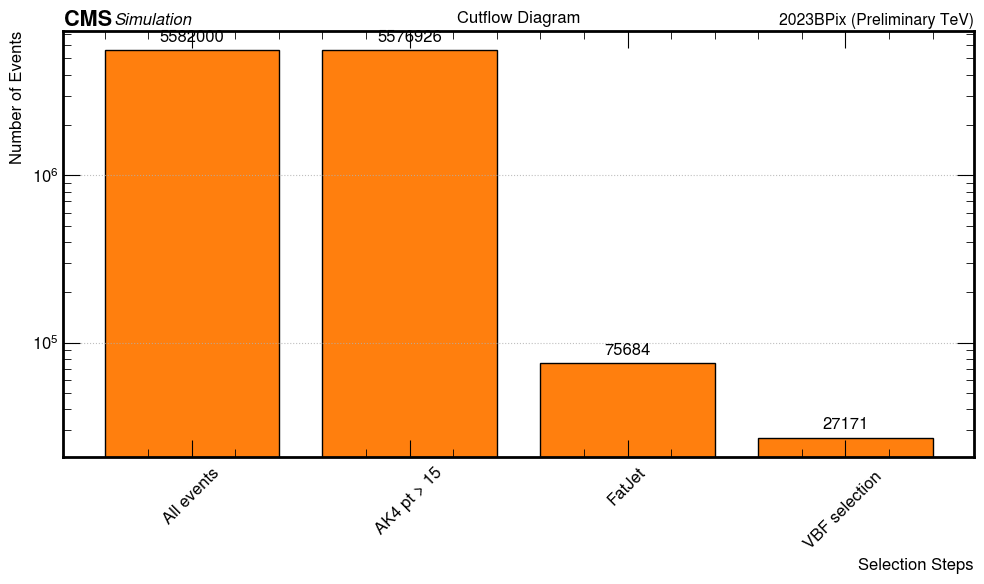

Currently processing production mode ggF


Output()

Output()

All events: 821534
AK4 pt > 15: 821533
FatJet: 180654
VBF selection : 7614


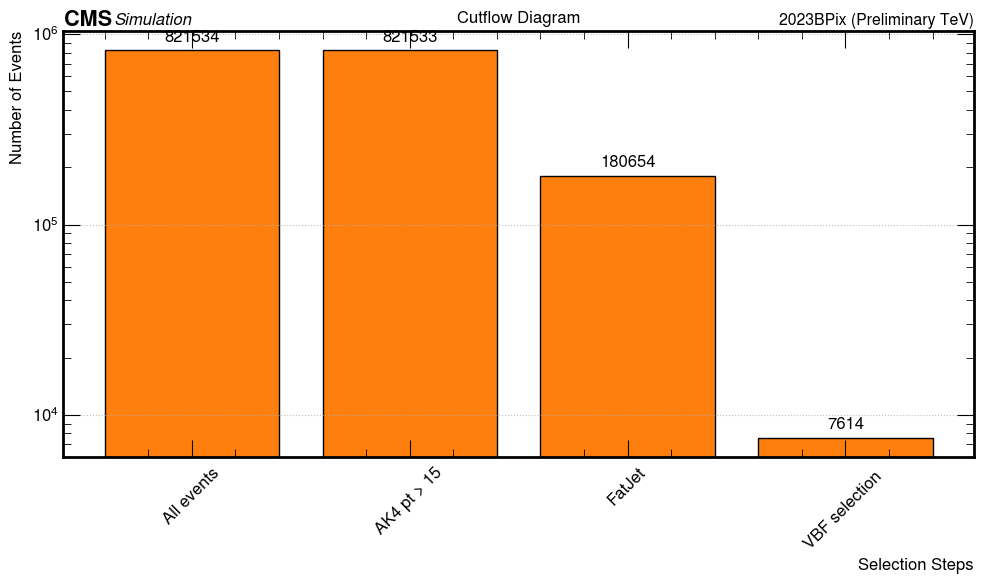

In [9]:
for year in ['2022', '2022EE', '2023', '2023BPix']:
# for year in ['2022', '2022EE']:
# for year in ['2023', '2023BPix']:
    print(f'Processing period {year}')
    file_dict = {'VBF': "VBF_Hto2B", 'ggF': "GluGlu_Hto2B"}
    outputs = {key_prod: [] for key_prod in file_dict.keys()}
    baseline_key = "new_w_xbb"
    for prod_mode, file_name in file_dict.items():
        print("Currently processing production mode", prod_mode)
        with open(f'/srv/{year}/{year}_{prod_mode}.json', 'r') as file:
            data = json.load(file)
        samples = data[file_name]
        samples = samples[:50]
        iterative_run = processor.Runner(
                executor = processor.FuturesExecutor(compression=None, workers=2),
                schema=NanoAODSchema,
                skipbadfiles=True,  # Skip files that fail to open
                savemetrics=True,   # Save metrics to understand where failures occur
        )
        fileset = {"Dataset" : samples}
        out = iterative_run(
            fileset,
            treename="Events",
            processor_instance=GeneralBaselineCutFlowProcessor(),
        )
        output = out[0]
        outputs[prod_mode] = output
    
        save_dir = f"/srv/figures/cutFlow/{year}/{baseline_key}_baseline/{prod_mode}"
        plot_cutflow(output, save_dir=save_dir, year=year)

Processing period 2022
Currently processing production mode VBF


Output()

Output()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


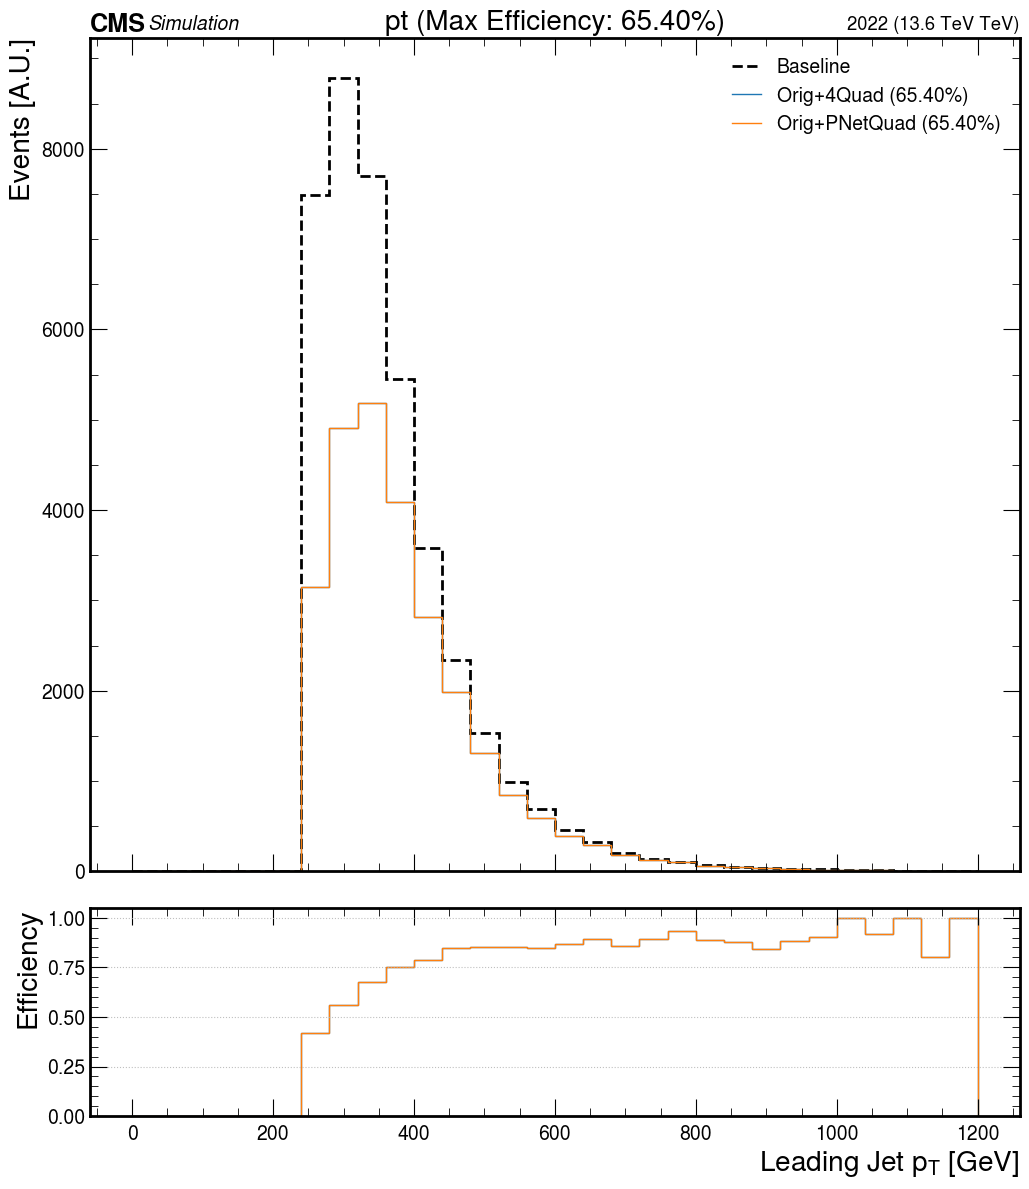

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


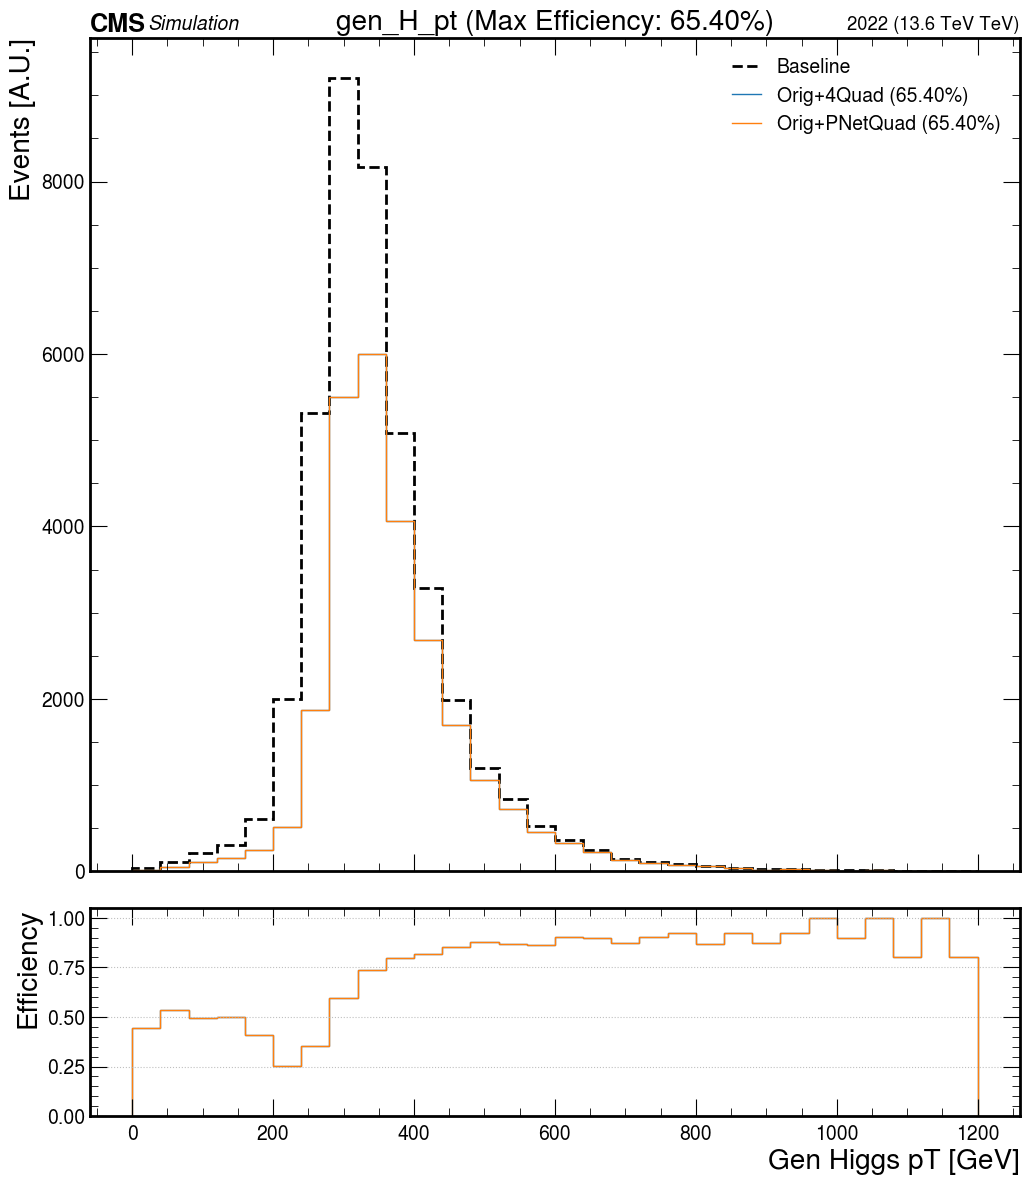

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Currently processing production mode ggF


Output()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


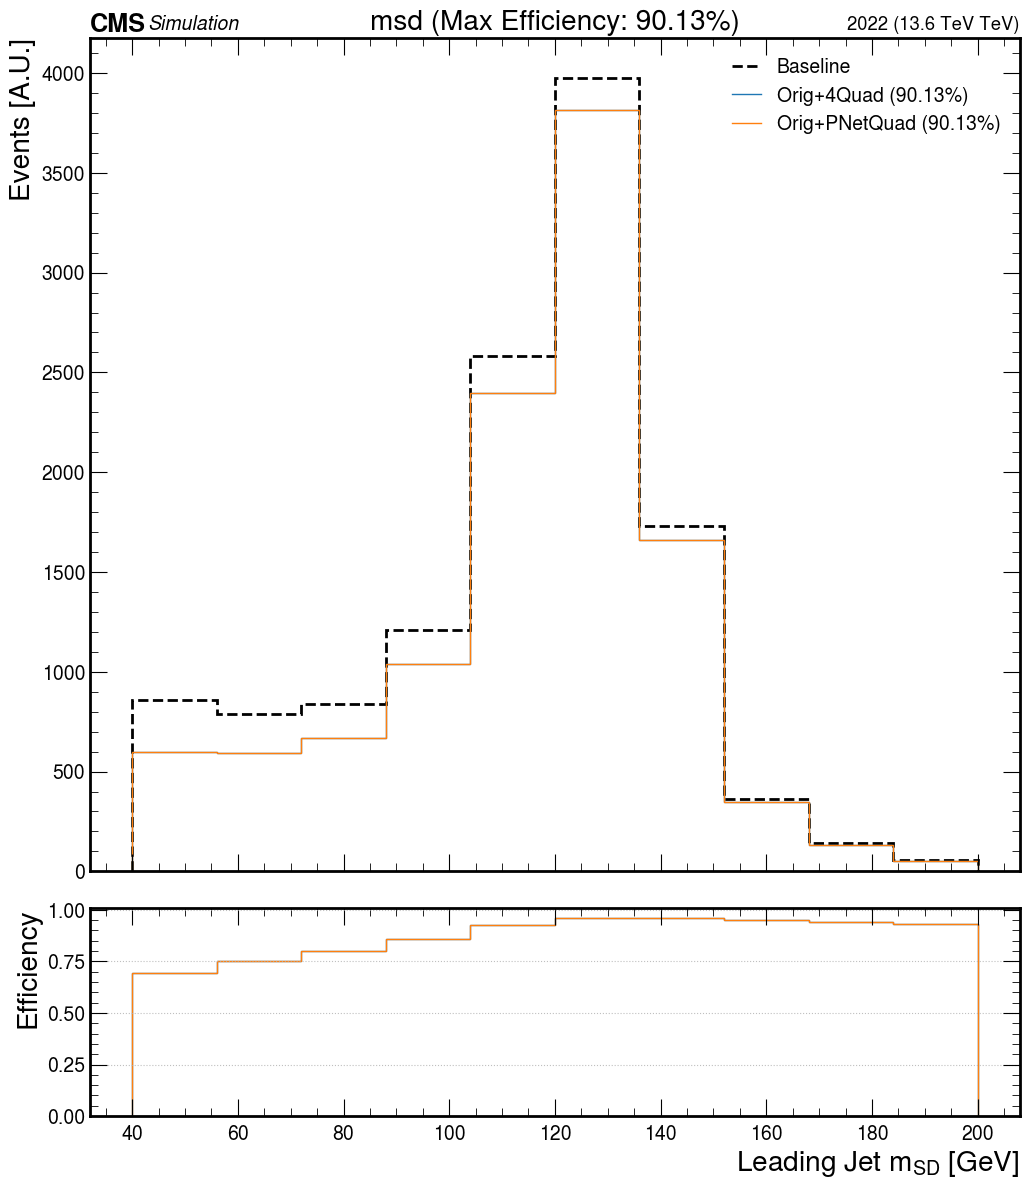

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


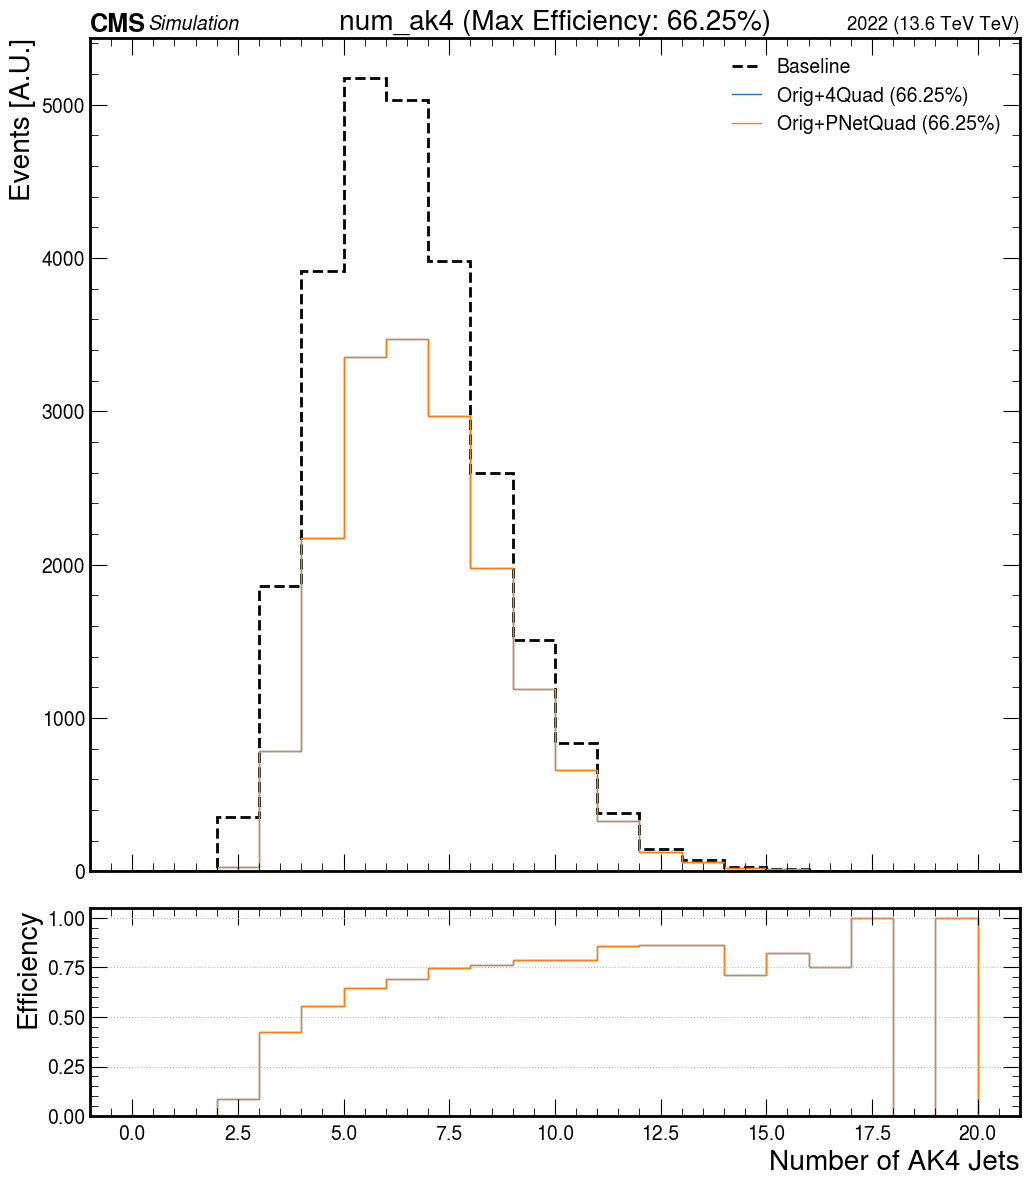

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


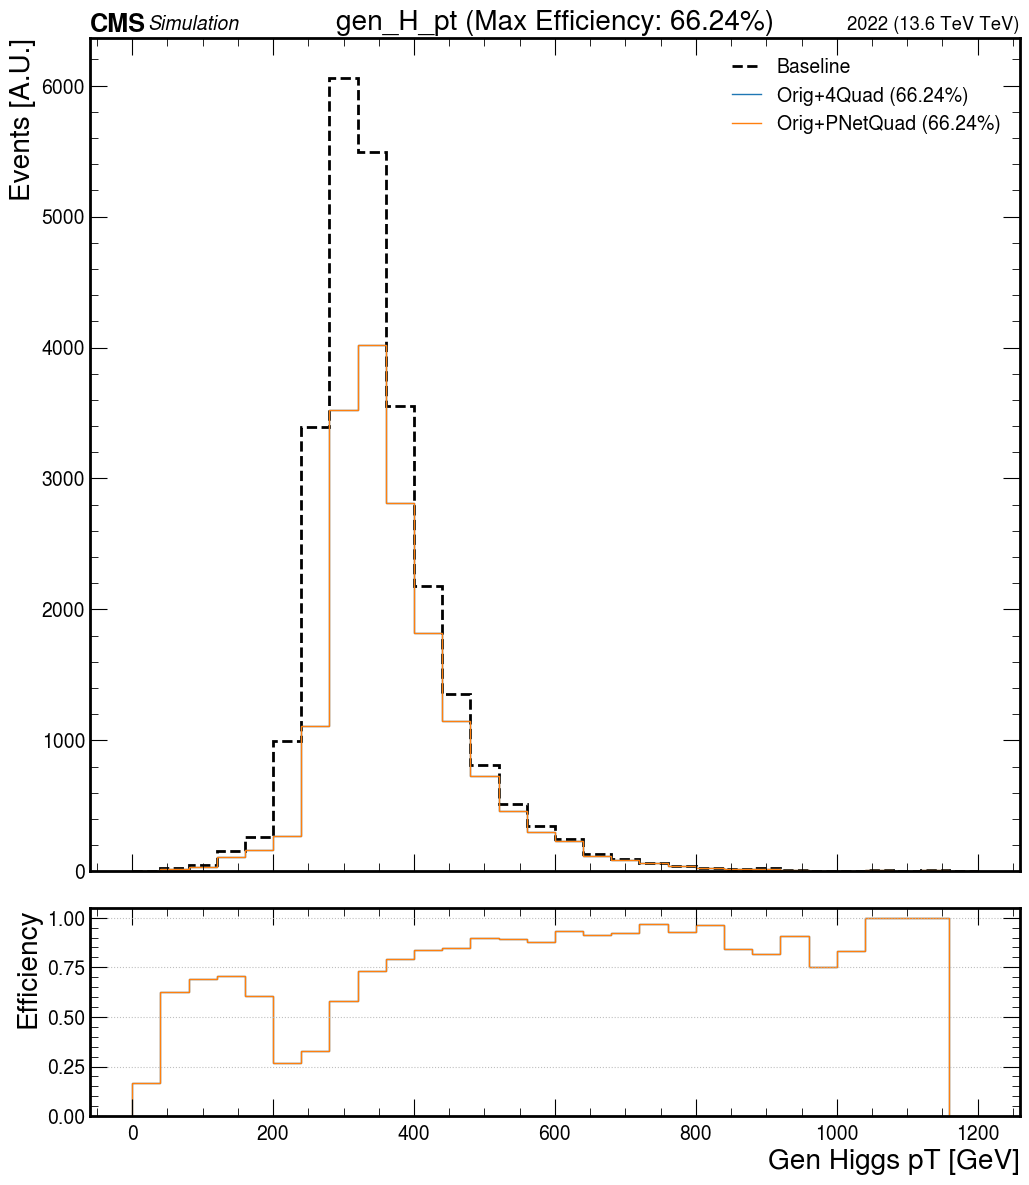

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


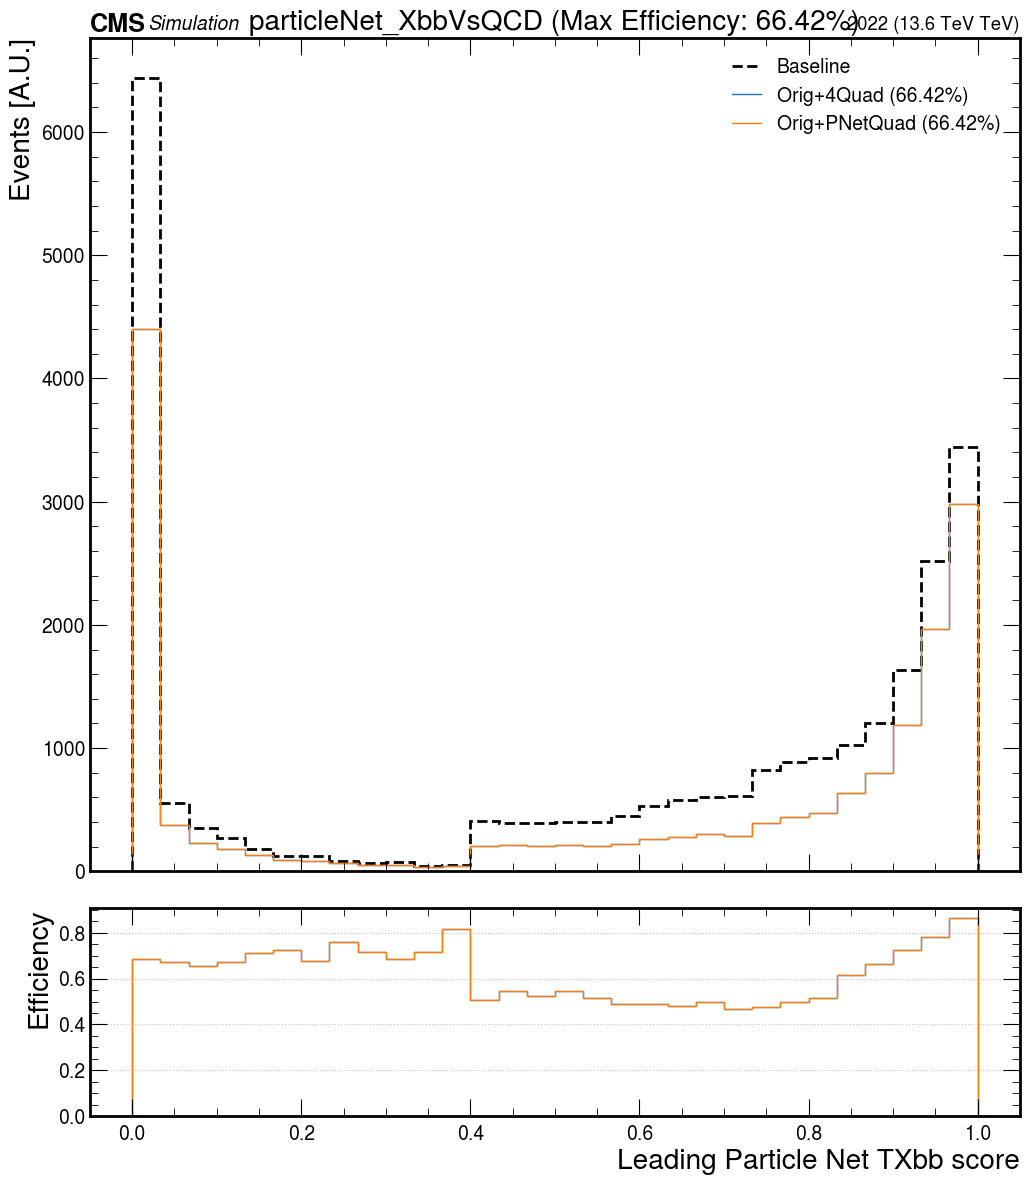

Processing period 2022EE
Currently processing production mode VBF


Output()

Output()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


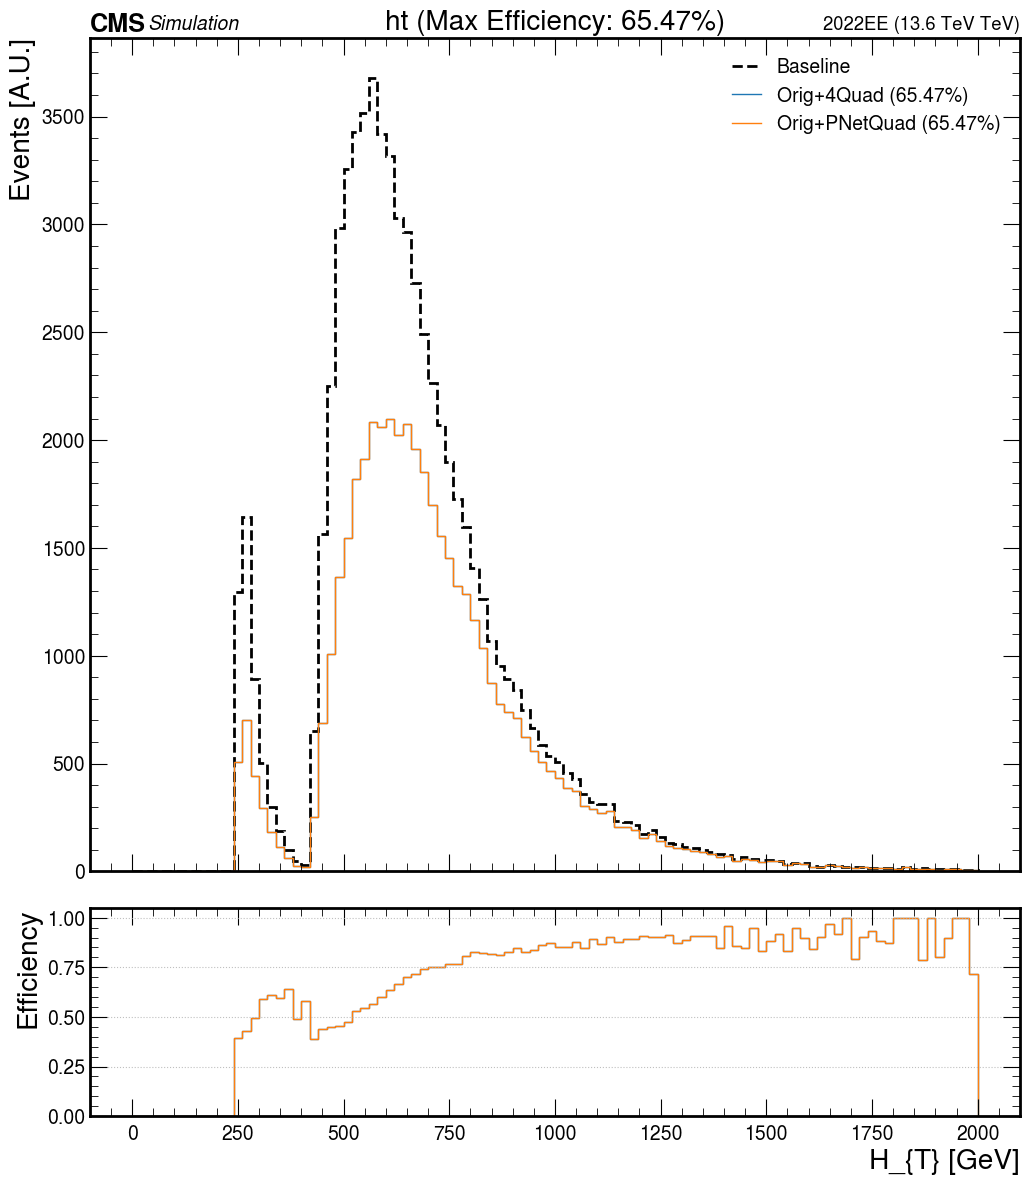

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


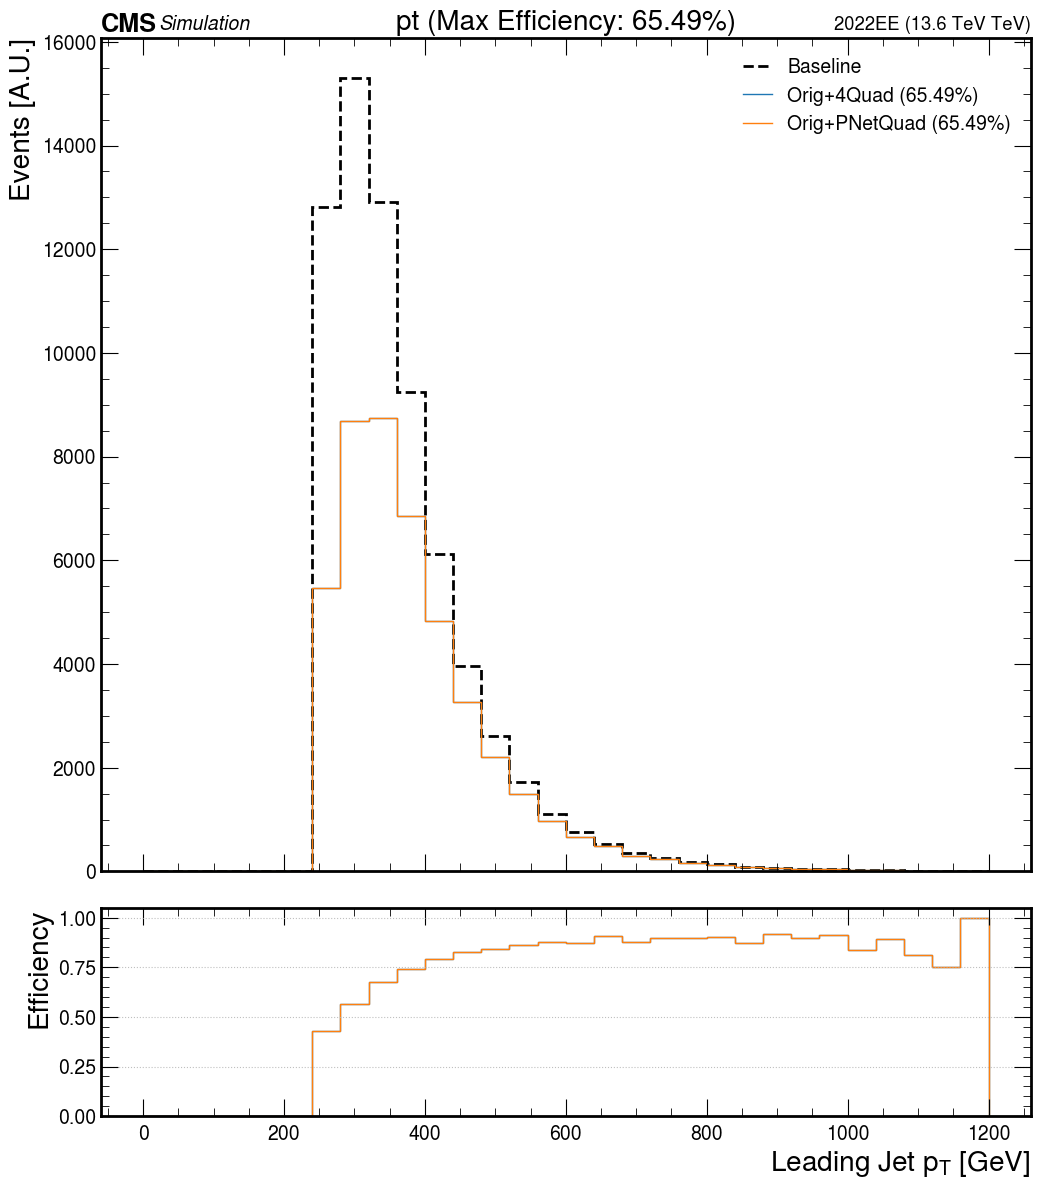

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


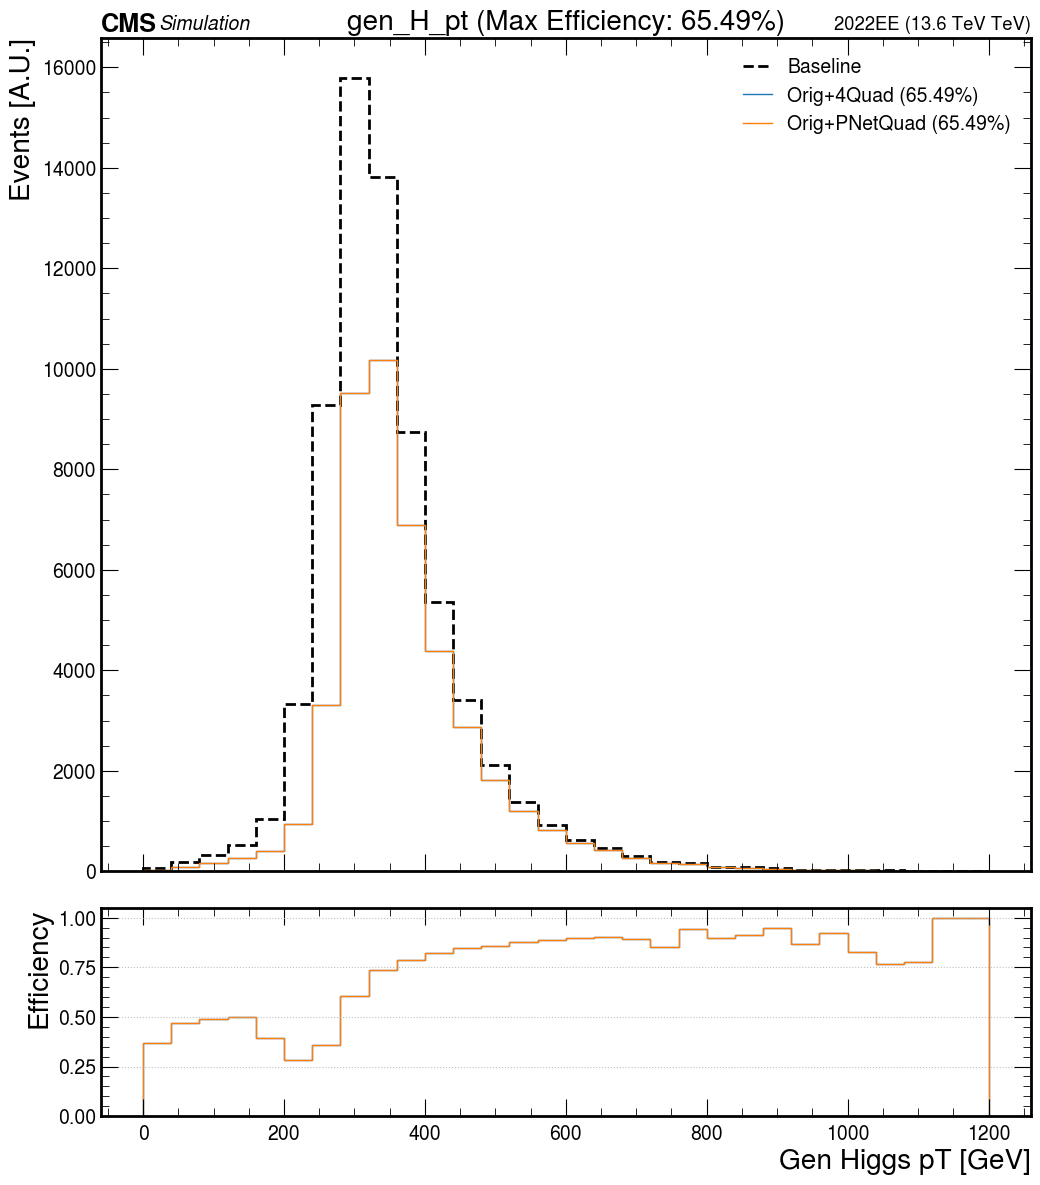

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Currently processing production mode ggF


Output()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


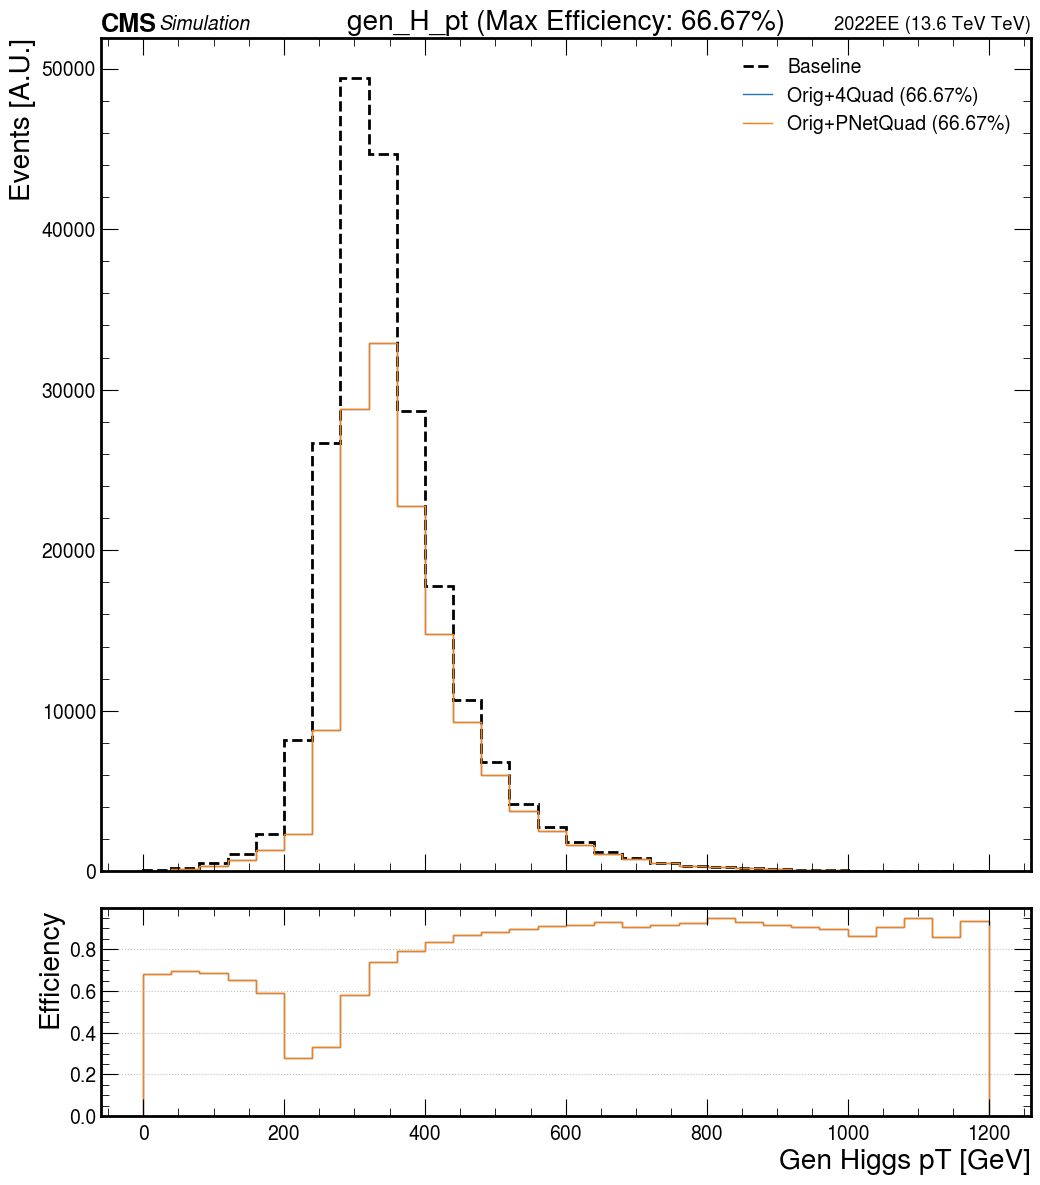

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


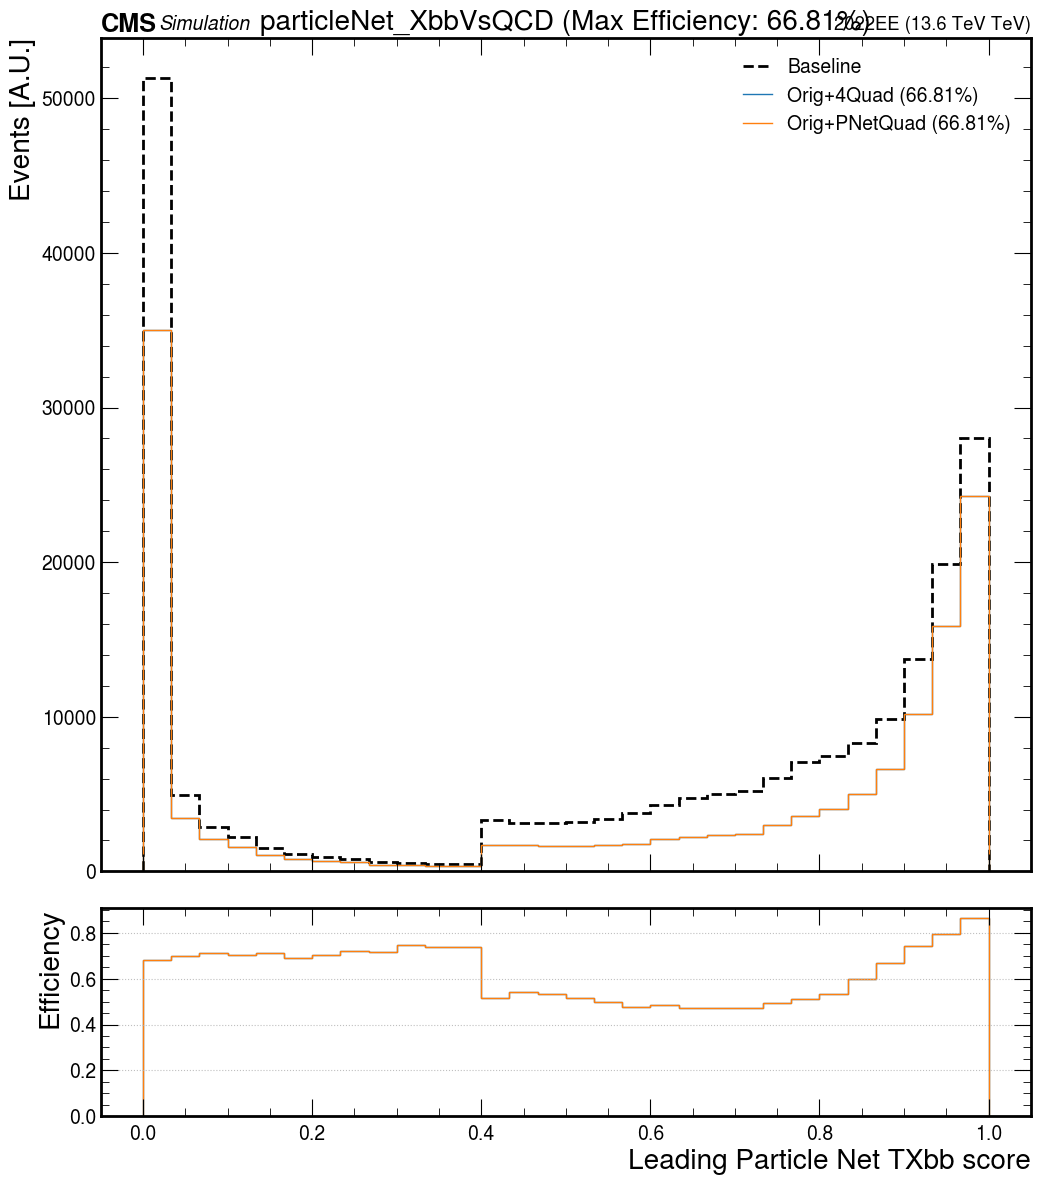

Processing period 2023
Currently processing production mode VBF


Output()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


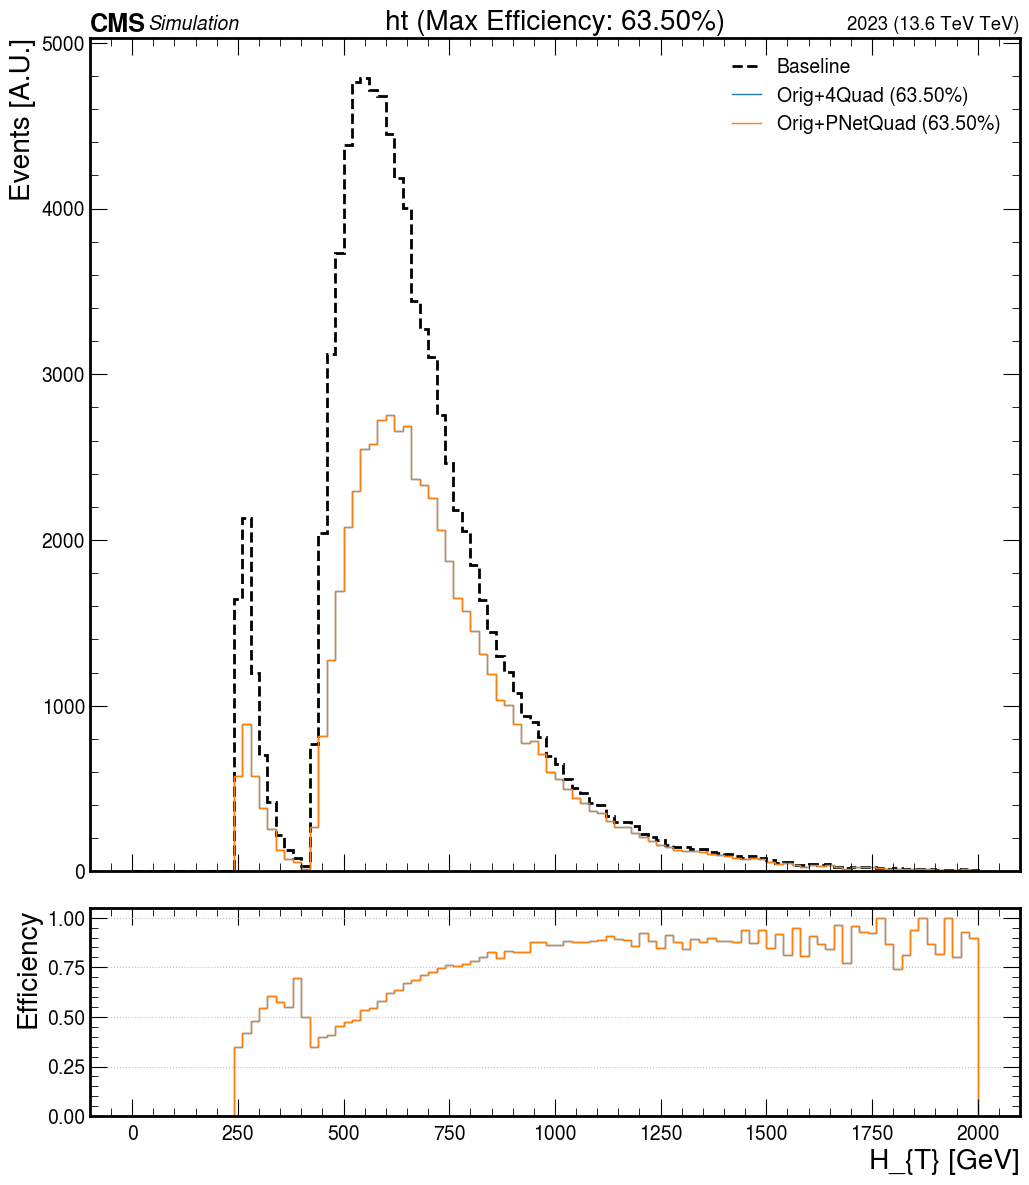

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


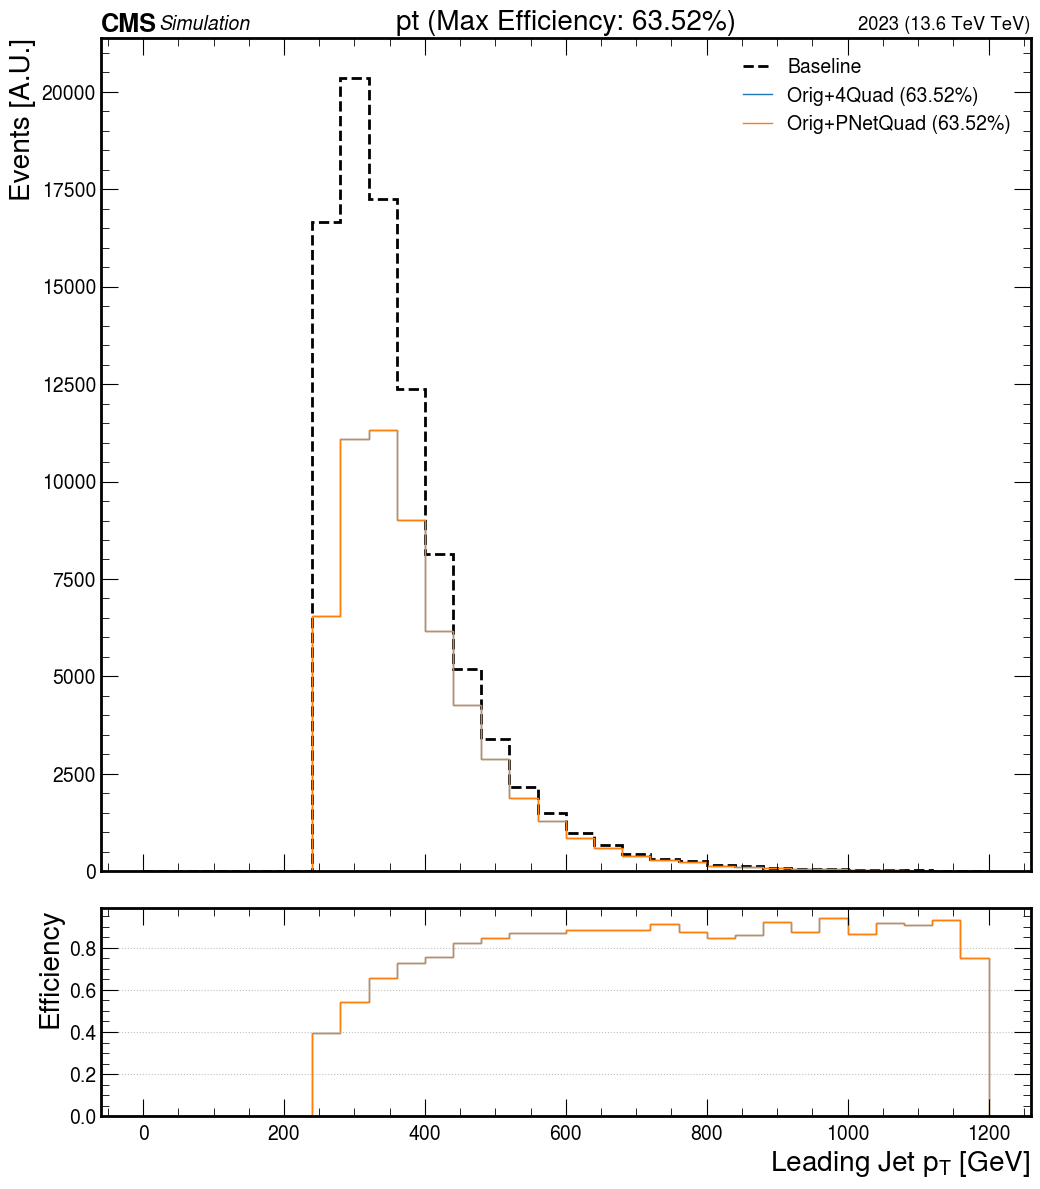

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


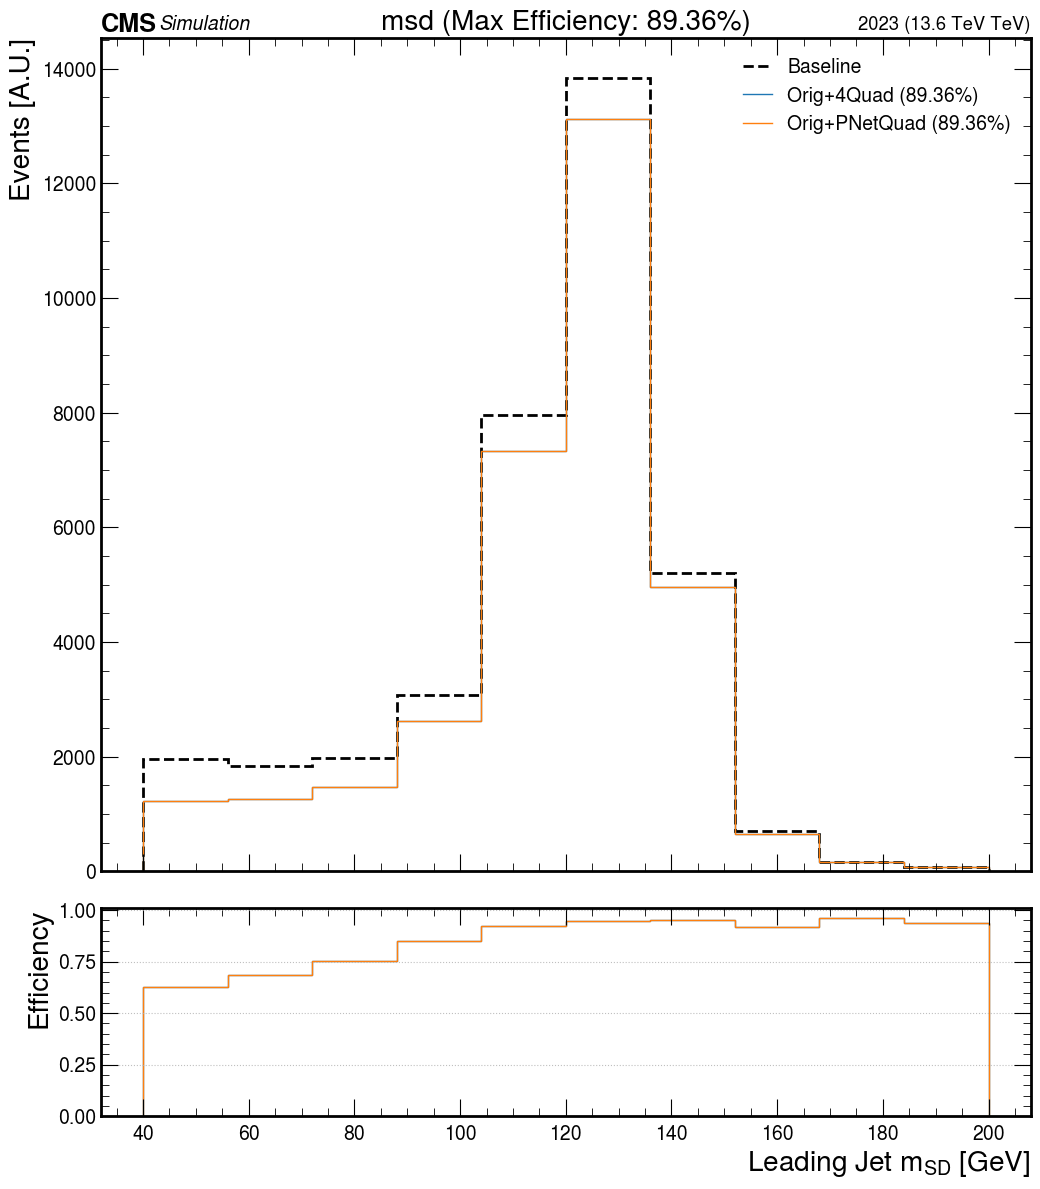

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


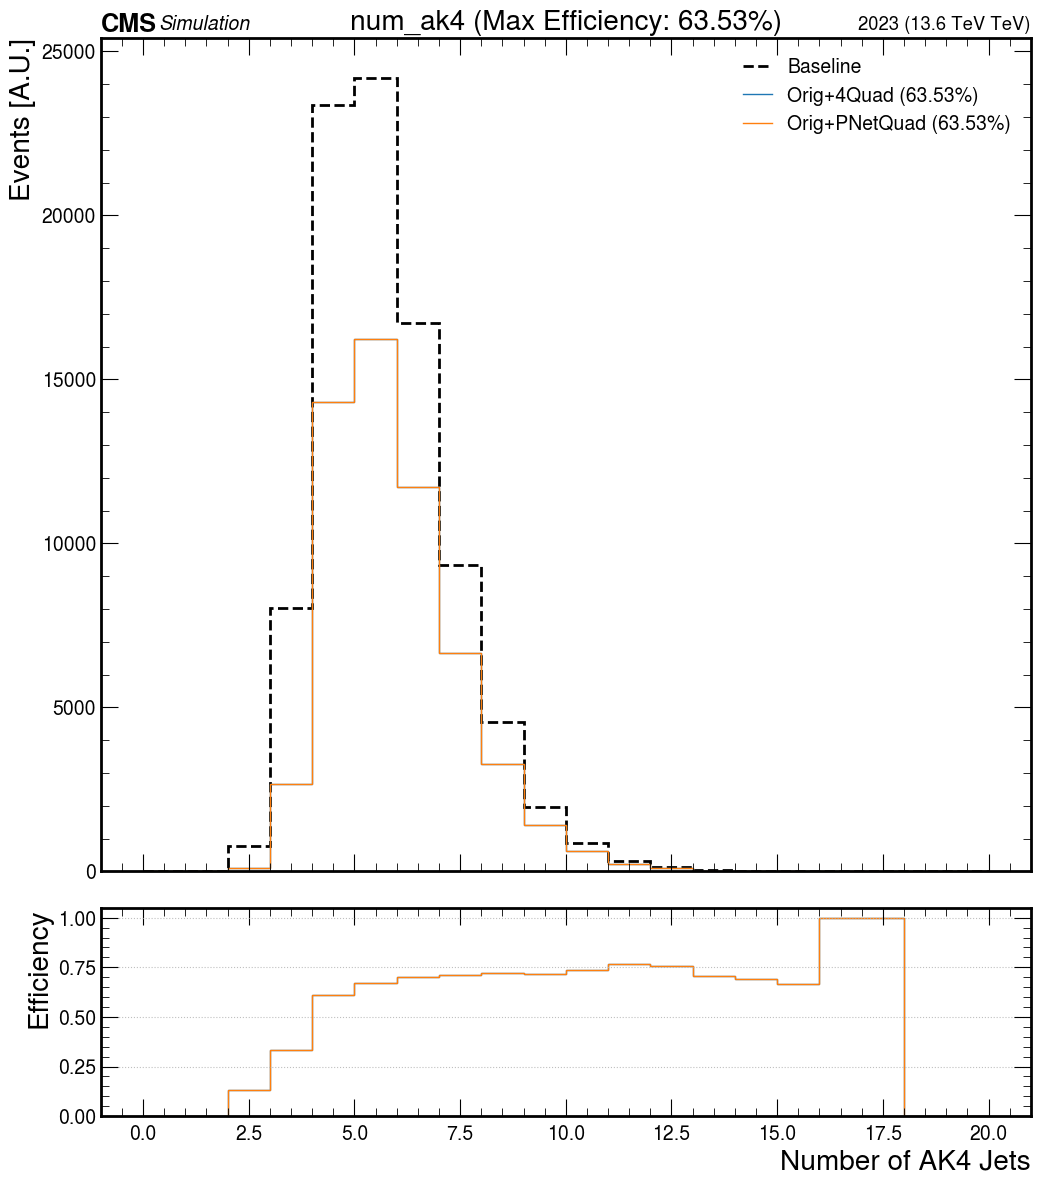

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


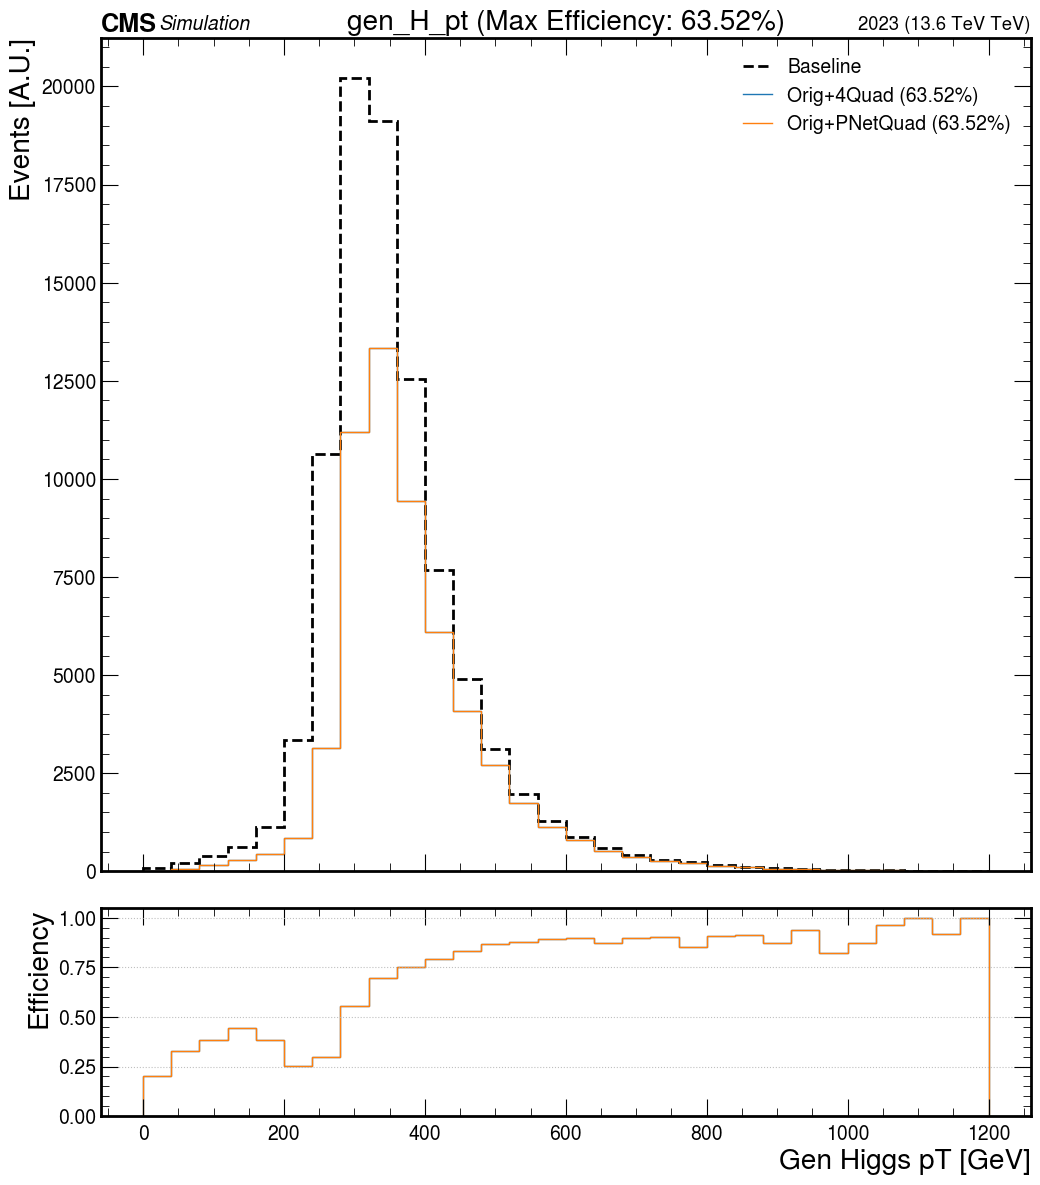

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Currently processing production mode ggF


Output()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


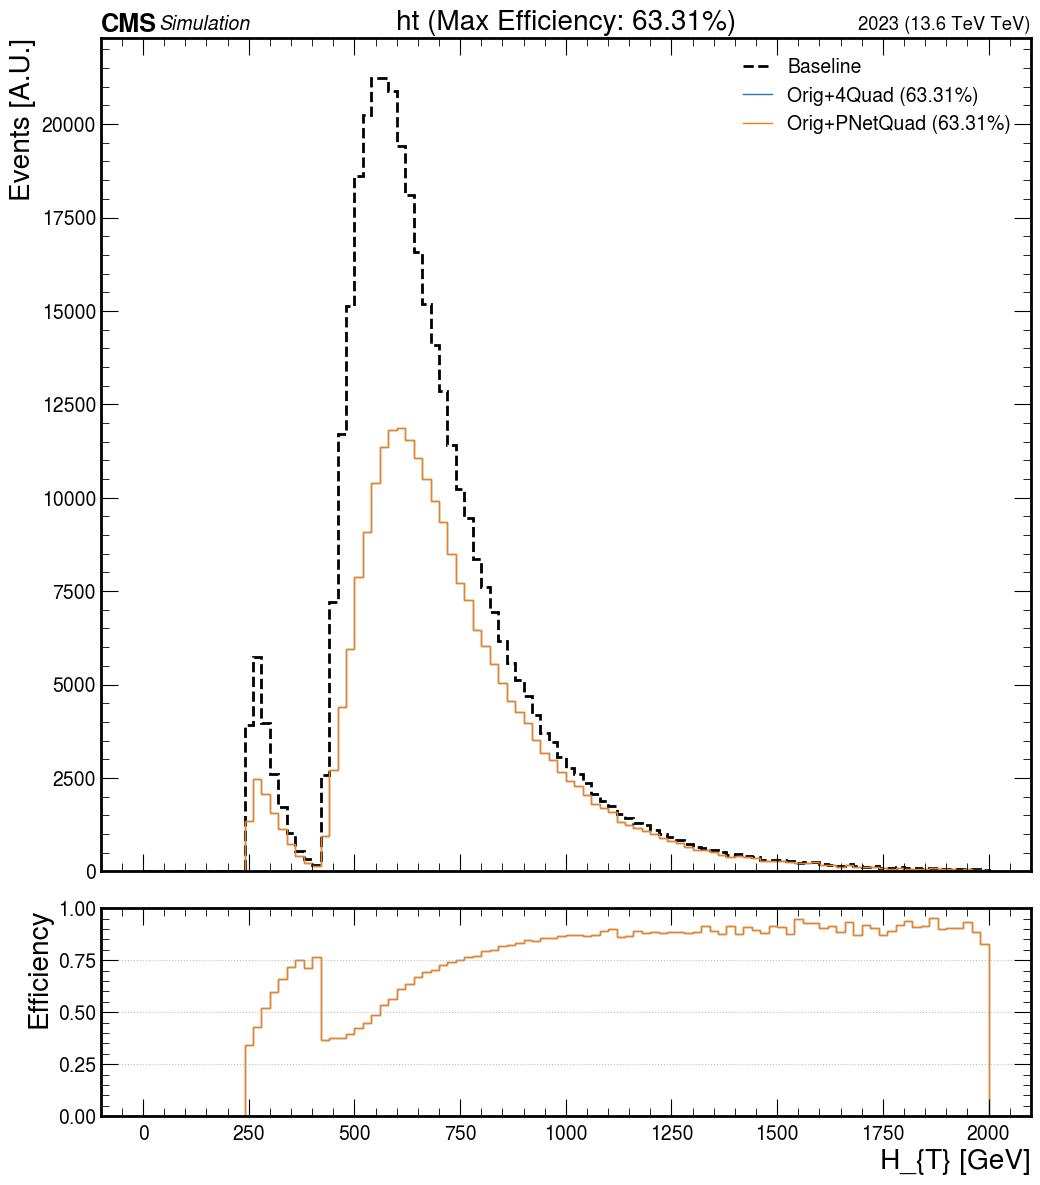

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


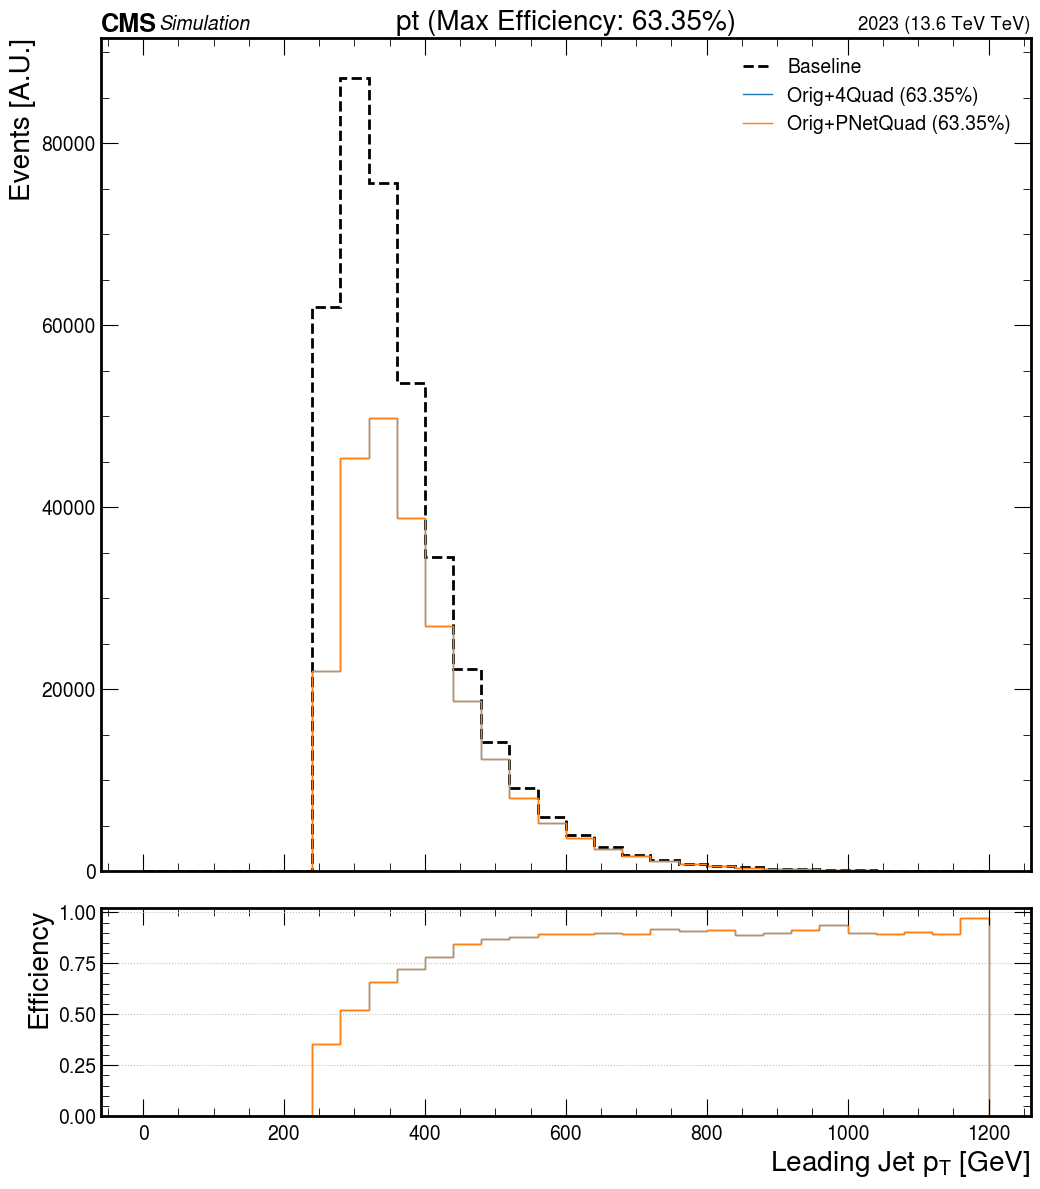

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


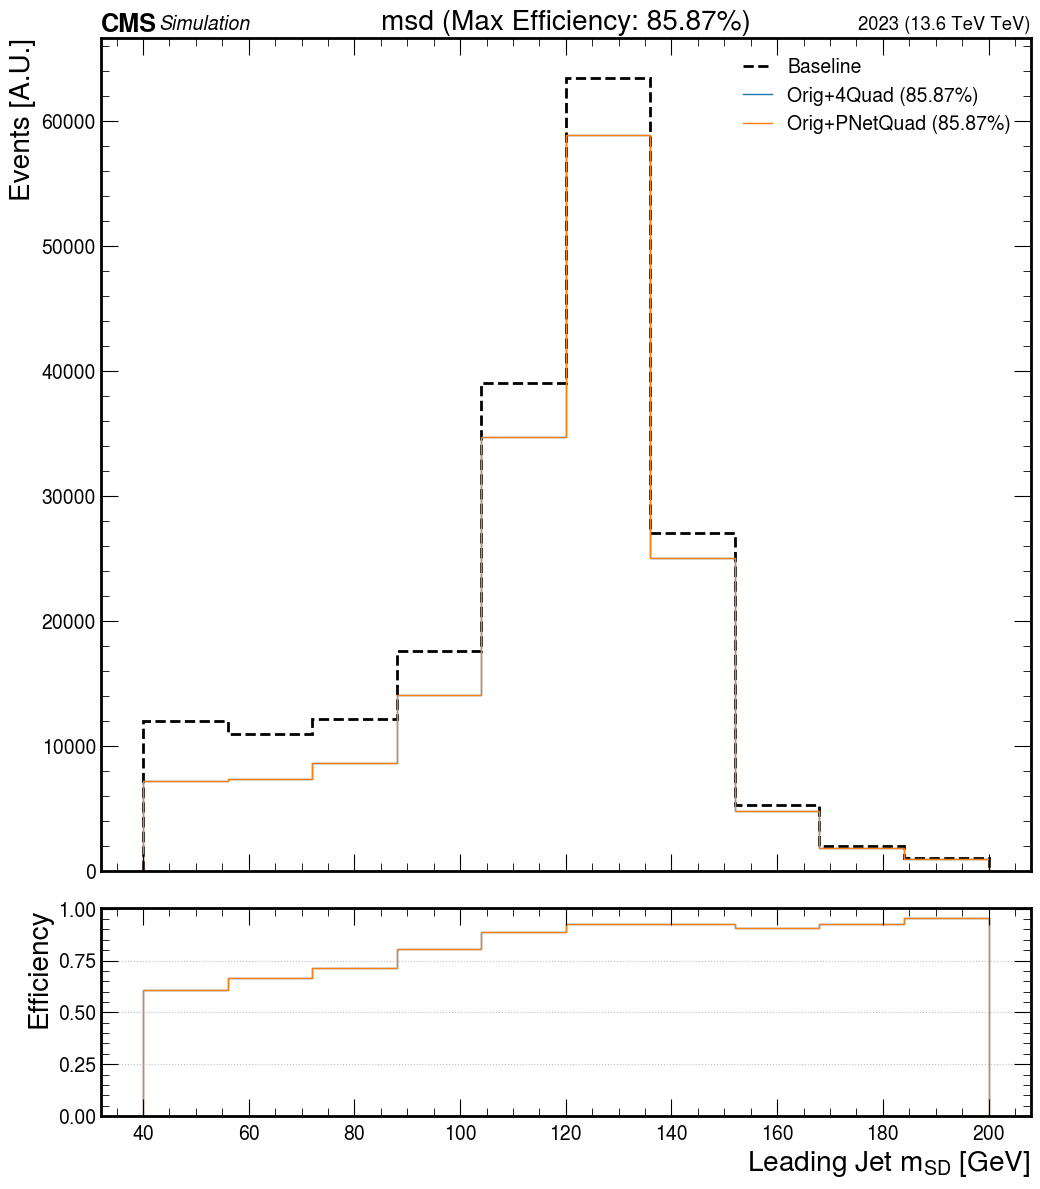

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


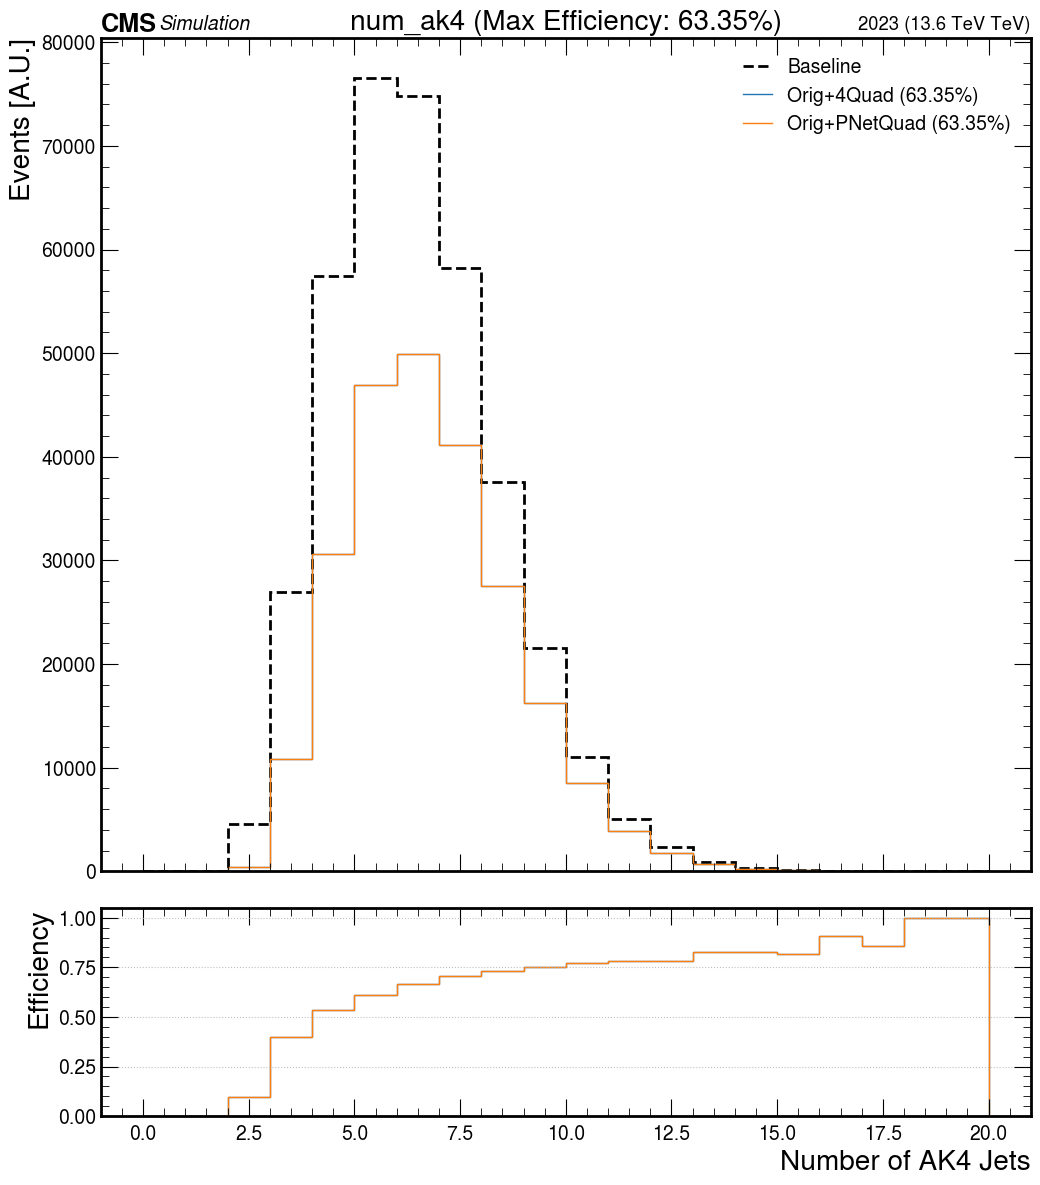

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


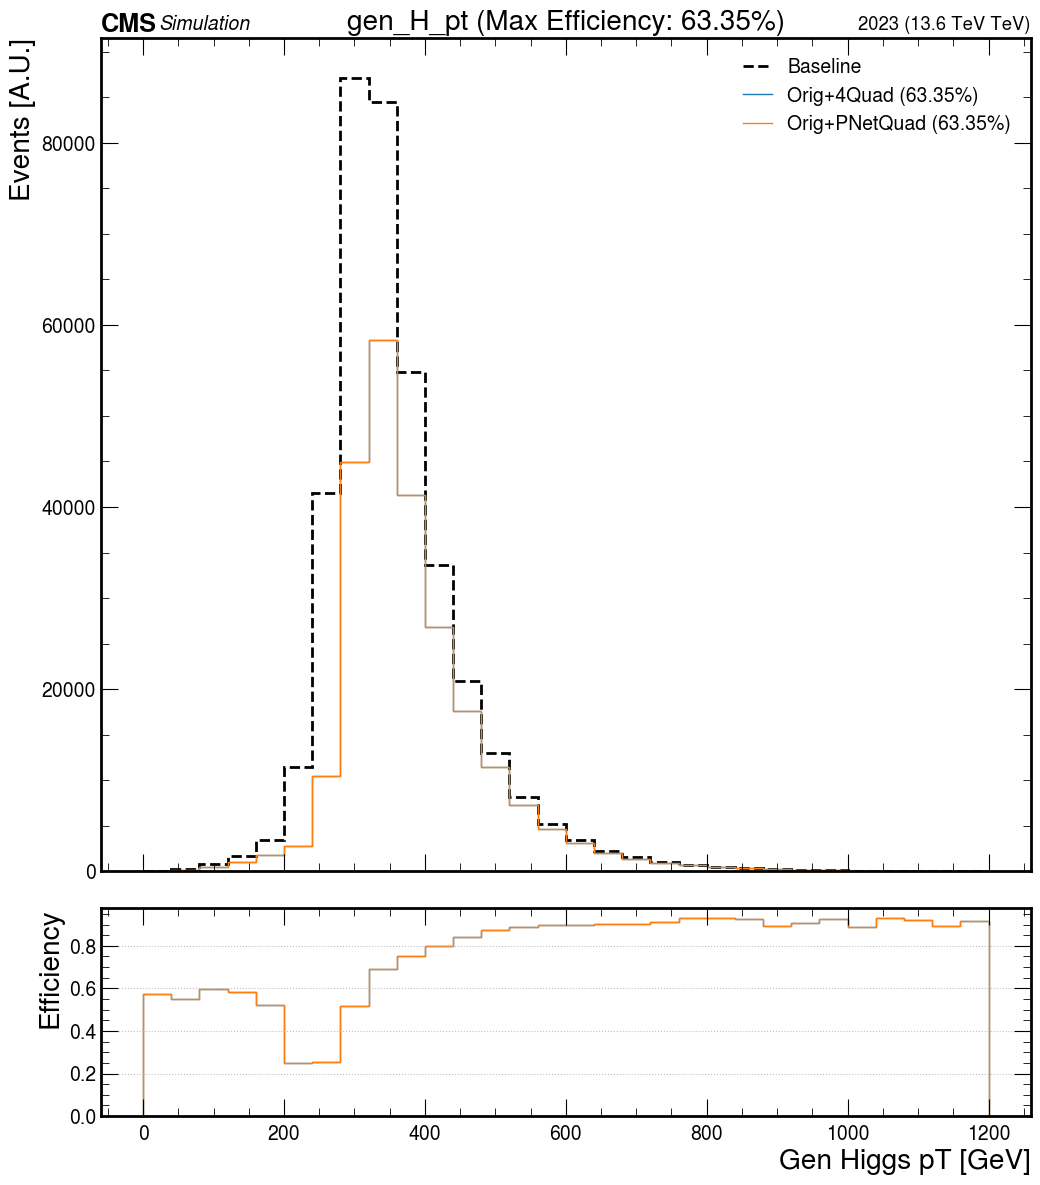

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


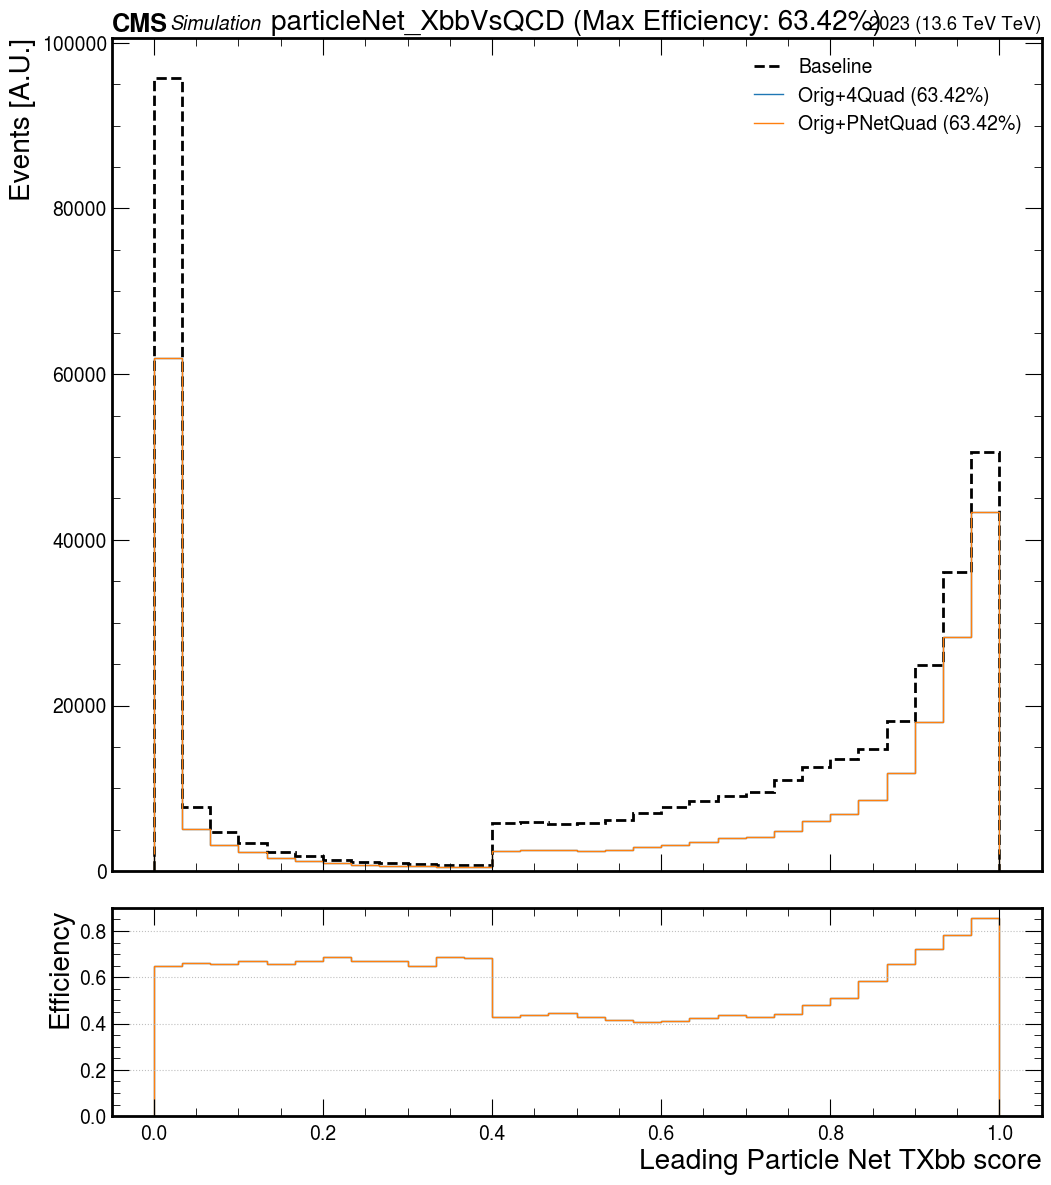

Processing period 2023BPix
Currently processing production mode VBF


Output()

In [ ]:
trigger_dict_periods = {
    '2022': [
        'AK8PFJet250_SoftDropMass40_PFAK8ParticleNetBB0p35',
        'AK8PFJet425_SoftDropMass40'
    ],
    '2022EE': [
        'AK8PFJet250_SoftDropMass40_PFAK8ParticleNetBB0p35',
        'AK8PFJet425_SoftDropMass40'
    ],
    '2023': [
        'AK8PFJet250_SoftDropMass40_PNetBB0p06',
        'AK8PFJet425_SoftDropMass40'
    ],
    '2023BPix': [
        'AK8PFJet250_SoftDropMass40_PNetBB0p06',
        'AK8PFJet425_SoftDropMass40'
    ]
}

quad_trigger_dict_periods = {
    '2022': [
        'QuadPFJet105_88_76_15_DoublePFBTagDeepJet_1p3_7p7_VBF1',
        'QuadPFJet70_50_40_35_PFBTagParticleNet_2BTagSum0p65',
        'QuadPFJet103_88_75_15_PFBTagDeepJet_1p3_VBF2',
        'QuadPFJet103_88_75_15_DoublePFBTagDeepJet_1p3_7p7_VBF1'
    ],
    '2022EE': [
        'QuadPFJet105_88_76_15_DoublePFBTagDeepJet_1p3_7p7_VBF1',
        'QuadPFJet70_50_40_35_PFBTagParticleNet_2BTagSum0p65',
        'QuadPFJet103_88_75_15_PFBTagDeepJet_1p3_VBF2',
        'QuadPFJet103_88_75_15_DoublePFBTagDeepJet_1p3_7p7_VBF1'
    ],
    '2023': [
        'QuadPFJet105_88_76_15_DoublePFBTagDeepJet_1p3_7p7_VBF1',
        'PFHT340_QuadPFJet70_50_40_40_PNet2BTagMean0p70',
        'QuadPFJet103_88_75_15_PFBTagDeepJet_1p3_VBF2',
        'QuadPFJet103_88_75_15_DoublePFBTagDeepJet_1p3_7p7_VBF1'
    ],
    '2023BPix': [
        'QuadPFJet105_88_76_15_DoublePFBTagDeepJet_1p3_7p7_VBF1',
        'PFHT340_QuadPFJet70_50_40_40_PNet2BTagMean0p70',
        'QuadPFJet103_88_75_15_PFBTagDeepJet_1p3_VBF2',
        'QuadPFJet103_88_75_15_DoublePFBTagDeepJet_1p3_7p7_VBF1'
    ]
}

# for year in ['2023', '2023BPix', '2022EE']:
for year in ['2022', '2022EE', '2023', '2023BPix']:
# for year in ['2022', '2022EE']:
# for year in ['2023', '2023BPix']:
    print(f'Processing period {year}')
    orig_trigger_soup = trigger_dict_periods[year]
    parking_trig_soup = quad_trigger_dict_periods[year]
    orig_plus_four_quad = orig_trigger_soup + parking_trig_soup
    orig_plus_PNet_quad = orig_trigger_soup + [parking_trig_soup[1]]
    file_dict = {'VBF': "VBF_Hto2B", 'ggF': "GluGlu_Hto2B"}
    outputs = {key_prod: [] for key_prod in file_dict.keys()}
    baseline_key = "new_w_xbb"
    for prod_mode, file_name in file_dict.items():
        print("Currently processing production mode", prod_mode)
        with open(f'/srv/{year}/{year}_{prod_mode}.json', 'r') as file:
            data = json.load(file)
        samples = data[file_name]
        samples = samples[:50]
        iterative_run = processor.Runner(
                executor = processor.FuturesExecutor(compression=None, workers=2),
                schema=NanoAODSchema,
                skipbadfiles=True,  # Skip files that fail to open
                savemetrics=True,   # Save metrics to understand where failures occur
        )
        fileset = {"Dataset" : samples}
        group_1_tag = 'Orig+4Quad'
        group_2_tag = 'Orig+PNetQuad'
        out = iterative_run(
            fileset,
            treename="Events",
            processor_instance=ParkingSoupProcessor(orig_plus_four_quad, orig_plus_PNet_quad, trig_vars, group_1_tag, group_2_tag, baseline_key=baseline_key),
        )
        output = out[0]
        outputs[prod_mode] = output
    
        save_dir = f"/srv/figures/PNet_quad/{year}/{baseline_key}_baseline/{prod_mode}/1d_trigger_soup"
        plot_1d_trigger_soup_cms(output, trig_vars, save_dir=save_dir, year=year)
        

In [ ]:
# for year in ['2022', '2022EE', '2023', '2023BPix']:
# for year in ['2022', '2022EE']:
for year in ['2023', '2023BPix']:
    print(f'Processing period {year}')
    orig_trigger_soup = trigger_dict_periods[year]
    parking_trig_soup = quad_trigger_dict_periods[year]
    orig_plus_PNet_plus_parking = orig_trigger_soup + ["VBF_DiPFJet125_45_Mjj720_Detajj3p0"]
    orig_plus_PNet_quad = orig_trigger_soup + [parking_trig_soup[1]]
    file_dict = {'VBF': "VBF_Hto2B", 'ggF': "GluGlu_Hto2B"}
    outputs = {key_prod: [] for key_prod in file_dict.keys()}
    baseline_key = "new_w_xbb"
    for prod_mode, file_name in file_dict.items():
        print("Currently processing production mode", prod_mode)
        with open(f'/srv/{year}/{year}_{prod_mode}.json', 'r') as file:
            data = json.load(file)
        samples = data[file_name]
        samples = samples[:50]
        iterative_run = processor.Runner(
                executor = processor.FuturesExecutor(compression=None, workers=2),
                schema=NanoAODSchema,
                skipbadfiles=True,  # Skip files that fail to open
                savemetrics=True,   # Save metrics to understand where failures occur
        )
        fileset = {"Dataset" : samples}
        group_1_tag = 'Orig+PNetQuad'
        group_2_tag = 'Orig+PNetQuad+Parking'
        out = iterative_run(
            fileset,
            treename="Events",
            processor_instance=ParkingSoupProcessor(orig_plus_PNet_quad, orig_plus_PNet_plus_parking, trig_vars, group_1_tag, group_2_tag, baseline_key=baseline_key),
        )
        output = out[0]
        outputs[prod_mode] = output
    
        save_dir = f"/srv/figures/PNet_quad_plus_parking/{year}/{baseline_key}_baseline/{prod_mode}/1d_trigger_soup"
        plot_1d_trigger_soup_cms(output, trig_vars, save_dir=save_dir, year=year)
        

In [ ]:
# vbf_parking_trigger_groups = {
#     "Group_A": [
#         "Mu10_TrkIsoVVL_DiPFJet40_DEta3p5_MJJ750_HTT350_PFMETNoMu60",
#         "Mu8_TrkIsoVVL_DiPFJet40_DEta3p5_MJJ750_HTT300_PFMETNoMu60",
#         "Mu4_TrkIsoVVL_DiPFJet90_40_DEta3p5_MJJ750_HTT300_PFMETNoMu60"
#     ],
#     "Group_B": [
#         "DiJet110_35_Mjj650_PFMET110",
#         "DiJet110_35_Mjj650_PFMET120",
#         "DiJet110_35_Mjj650_PFMET130",
#         "TripleJet110_35_35_Mjj650_PFMET110",
#         "TripleJet110_35_35_Mjj650_PFMET120",
#         "TripleJet110_35_35_Mjj650_PFMET130"
#     ],
#     "Group_C": [
#         "QuadPFJet103_88_75_15_DoublePFBTagDeepJet_1p3_7p7_VBF1",
#         "QuadPFJet103_88_75_15_PFBTagDeepJet_1p3_VBF2",
#         "QuadPFJet105_88_76_15_DoublePFBTagDeepJet_1p3_7p7_VBF1",
#         "QuadPFJet105_88_76_15_PFBTagDeepJet_1p3_VBF2",
#         "QuadPFJet111_90_80_15_DoublePFBTagDeepJet_1p3_7p7_VBF1",
#         "QuadPFJet111_90_80_15_PFBTagDeepJet_1p3_VBF2"
#     ],
#     "Group_D": [
#         "QuadPFJet100_88_70_30_PNet1CvsAll0p5_VBF3Tight",
#         "QuadPFJet105_88_75_30_PNet1CvsAll0p5_VBF3Tight",
#         "QuadPFJet111_90_80_30_PNet1CvsAll0p6_VBF3Tight"
#     ],
#     "Group_E": [
#         "VBF_DiPFJet70_40_Mjj600_Detajj2p5_DiPFJet60_JetMatchingQuadJet",
#         "VBF_DiPFJet70_40_Mjj600_Detajj2p5_DiPFJet60_JetMatchingFiveJet",
#         "VBF_DiPFJet70_40_Mjj600_Detajj2p5_DiPFJet60_JetMatchingSixJet",
#         "VBF_DiPFJet75_45_Mjj600_Detajj2p5_DiPFJet60_JetMatchingQuadJet",
#         "VBF_DiPFJet75_45_Mjj600_Detajj2p5_DiPFJet60_JetMatchingFiveJet",
#         "VBF_DiPFJet75_45_Mjj600_Detajj2p5_DiPFJet60_JetMatchingSixJet"
#     ],
#     "Group_F": [
#         "VBF_DiPFJet75_40_Mjj500_Detajj2p5_PFMET85",
#         "VBF_DiPFJet75_40_Mjj500_Detajj2p5_PFMET85_TriplePFJet"
#     ],
#     "Group_F2": [
#         "VBF_DiPFJet80_45_Mjj500_Detajj2p5_PFMET85",
#         "VBF_DiPFJet80_45_Mjj500_Detajj2p5_PFMET85_TriplePFJet"
#     ],
#     "Group_G": [
#         "VBF_DiPFJet90_40_Mjj600_Detajj2p5_Mu3_TrkIsoVVL",
#         "VBF_DiPFJet90_40_Mjj600_Detajj2p5_Mu3_TrkIsoVVL_TriplePFJet"
#     ],
#     "Group_H": [
#         "VBF_DiPFJet95_45_Mjj600_Detajj2p5_Mu3_TrkIsoVVL",
#         "VBF_DiPFJet95_45_Mjj600_Detajj2p5_Mu3_TrkIsoVVL_TriplePFJet"
#     ],
#     "Group_I": [
#         "VBF_DiPFJet45_Mjj500_Detajj2p5_MediumDeepTauPFTauHPS45_L2NN_eta2p1",
#         "VBF_DoubleMediumDeepTauPFTauHPS20_eta2p1",
#         "DoublePFJets40_Mass500_MediumDeepTauPFTauHPS45_L2NN_MediumDeepTauPFTauHPS20_eta2p1"
#     ],
#     "Group_J": [
#         "VBF_DiPFJet105_40_Mjj1000_Detajj3p5",
#         "VBF_DiPFJet105_40_Mjj1000_Detajj3p5_TriplePFJet",
#         "VBF_DiPFJet110_40_Mjj1000_Detajj3p5",
#         "VBF_DiPFJet110_40_Mjj1000_Detajj3p5_TriplePFJet",
#         "VBF_DiPFJet125_45_Mjj1000_Detajj3p5",
#         "VBF_DiPFJet125_45_Mjj1000_Detajj3p5_TriplePFJet"
#     ],
#     "Group_K": {
#         "Photon": [
#             "VBF_DiPFJet45_Mjj500_Detajj2p5_Photon12",
#             "VBF_DiPFJet45_Mjj500_Detajj2p5_Photon17",
#             "VBF_DiPFJet50_Mjj500_Detajj2p5_Photon22"
#         ],
#         "Electron": [
#             "VBF_DiPFJet45_Mjj500_Detajj2p5_Ele12_eta2p1_WPTight_Gsf",
#             "VBF_DiPFJet45_Mjj500_Detajj2p5_Ele17_eta2p1_WPTight_Gsf",
#             "VBF_DiPFJet50_Mjj500_Detajj2p5_Ele22_eta2p1_WPTight_Gsf"
#         ]
#     },
#     "Group_M": [
#         "VBF_DiPFJet125_45_Mjj720_Detajj3p0",
#         "VBF_DiPFJet125_45_Mjj720_Detajj3p0"
#         "VBF_DiPFJet125_45_Mjj720_Detajj3p0_TriplePFJet"
#     ]
# }

# lowest_threshold_triggers_list = [
#     "Mu8_TrkIsoVVL_DiPFJet40_DEta3p5_MJJ750_HTT300_PFMETNoMu60",  # Group A
#     "DiJet110_35_Mjj650_PFMET110",                                  # Group B
#     "QuadPFJet103_88_75_15_PFBTagDeepJet_1p3_VBF2",                 # Group C
#     "QuadPFJet100_88_70_30_PNet1CvsAll0p5_VBF3Tight",               # Group D
#     "VBF_DiPFJet70_40_Mjj600_Detajj2p5_DiPFJet60_JetMatchingQuadJet",# Group E
#     "VBF_DiPFJet75_40_Mjj500_Detajj2p5_PFMET85",                     # Group F
#     "VBF_DiPFJet80_45_Mjj500_Detajj2p5_PFMET85",                     # Group F2
#     "VBF_DiPFJet90_40_Mjj600_Detajj2p5_Mu3_TrkIsoVVL",               # Group G
#     "VBF_DiPFJet95_45_Mjj600_Detajj2p5_Mu3_TrkIsoVVL",               # Group H
#     "VBF_DoubleMediumDeepTauPFTauHPS20_eta2p1",                      # Group I
#     "VBF_DiPFJet105_40_Mjj1000_Detajj3p5",                           # Group J
#     "VBF_DiPFJet45_Mjj500_Detajj2p5_Photon12",                       # Group K (Photon)
#     "VBF_DiPFJet45_Mjj500_Detajj2p5_Ele12_eta2p1_WPTight_Gsf",        # Group K (Electron)
#     "VBF_DiPFJet125_45_Mjj720_Detajj3p0"                             # Group M
# ]


In [ ]:
# for year in ['2023', '2023BPix']:
#     print(f'Processing period {year}')
#     file_dict = {'VBF': "VBF_Hto2B", 'ggF': "GluGlu_Hto2B"}
#     outputs = {key_prod: [] for key_prod in file_dict.keys()}
#     baseline_key = "general"
#     for prod_mode, file_name in file_dict.items():
#         print("Currently processing production mode", prod_mode)
#         with open(f'/srv/{year}/{year}_{prod_mode}.json', 'r') as file:
#             data = json.load(file)
#         samples = data[file_name]
#         samples = samples[:20]
#         iterative_run = processor.Runner(
#                 executor = processor.FuturesExecutor(compression=None, workers=2),
#                 schema=NanoAODSchema,
#                 skipbadfiles=True,  # Skip files that fail to open
#                 savemetrics=True,   # Save metrics to understand where failures occur
#         )
#         fileset = {"Dataset" : samples}
#         out = iterative_run(
#             fileset,
#             treename="Events",
#             processor_instance=TriggerSoupProcessor_individual(lowest_threshold_triggers_list, trig_vars, baseline_key=baseline_key),
#         )
#         output = out[0]
#         outputs[prod_mode] = output
    
#         save_dir = f"/srv/figures/vbf_parking/{year}/{baseline_key}_baseline/{prod_mode}/1d_trigger_soup"
#         plot_1d_trigger_soup_cms_trial(output, trig_vars, save_dir=save_dir, year=year)

In [ ]:
# good_vbf_parking_trigger_groups = {
#     "QuadPFJet_DeepJet_VBF": [
#         "QuadPFJet103_88_75_15_DoublePFBTagDeepJet_1p3_7p7_VBF1",
#         "QuadPFJet103_88_75_15_PFBTagDeepJet_1p3_VBF2",
#         "QuadPFJet105_88_76_15_DoublePFBTagDeepJet_1p3_7p7_VBF1",
#         "QuadPFJet105_88_76_15_PFBTagDeepJet_1p3_VBF2",
#         "QuadPFJet111_90_80_15_DoublePFBTagDeepJet_1p3_7p7_VBF1",
#         "QuadPFJet111_90_80_15_PFBTagDeepJet_1p3_VBF2"
#     ],
#     "VBF_DiPFJet_JetMatching": [
#         "VBF_DiPFJet70_40_Mjj600_Detajj2p5_DiPFJet60_JetMatchingQuadJet",
#         "VBF_DiPFJet70_40_Mjj600_Detajj2p5_DiPFJet60_JetMatchingFiveJet",
#         "VBF_DiPFJet70_40_Mjj600_Detajj2p5_DiPFJet60_JetMatchingSixJet",
#         "VBF_DiPFJet75_45_Mjj600_Detajj2p5_DiPFJet60_JetMatchingQuadJet",
#         "VBF_DiPFJet75_45_Mjj600_Detajj2p5_DiPFJet60_JetMatchingFiveJet",
#         "VBF_DiPFJet75_45_Mjj600_Detajj2p5_DiPFJet60_JetMatchingSixJet"
#     ],
#     "HighMass_VBF_DiPFJet_Mjj1000": [
#         "VBF_DiPFJet105_40_Mjj1000_Detajj3p5",
#         "VBF_DiPFJet105_40_Mjj1000_Detajj3p5_TriplePFJet",
#         "VBF_DiPFJet110_40_Mjj1000_Detajj3p5",
#         "VBF_DiPFJet110_40_Mjj1000_Detajj3p5_TriplePFJet",
#         "VBF_DiPFJet125_45_Mjj1000_Detajj3p5",
#         "VBF_DiPFJet125_45_Mjj1000_Detajj3p5_TriplePFJet"
#     ],
#     "IntermediateMass_VBF_DiPFJet_Mjj720": [
#         "VBF_DiPFJet125_45_Mjj720_Detajj3p0",
#         "VBF_DiPFJet125_45_Mjj720_Detajj3p0_TriplePFJet"
#     ]
# }

# for year in ['2023', '2023BPix']:
#     print(f'Processing period {year}')
#     file_dict = {'VBF': "VBF_Hto2B"}
#     outputs = {key_prod: [] for key_prod in file_dict.keys()}
#     baseline_key = "general"
#     for group_name in good_vbf_parking_trigger_groups.keys():
#         print(f"Processing {group_name}")
#         triggers = good_vbf_parking_trigger_groups[group_name]
#         for prod_mode, file_name in file_dict.items():
#             print("Currently processing production mode", prod_mode)
#             with open(f'/srv/{year}/{year}_{prod_mode}.json', 'r') as file:
#                 data = json.load(file)
#             samples = data[file_name]
#             samples = samples[:20]
#             iterative_run = processor.Runner(
#                     executor = processor.FuturesExecutor(compression=None, workers=2),
#                     schema=NanoAODSchema,
#                     skipbadfiles=True,  # Skip files that fail to open
#                     savemetrics=True,   # Save metrics to understand where failures occur
#             )
#             fileset = {"Dataset" : samples}
#             out = iterative_run(
#                 fileset,
#                 treename="Events",
#                 processor_instance=TriggerSoupProcessor_individual(triggers, trig_vars, baseline_key=baseline_key),
#             )
#             output = out[0]
#             outputs[prod_mode] = output
        
#             save_dir = f"/srv/figures/vbf_parking/{group_name}/{year}/{baseline_key}_baseline/{prod_mode}/1d_trigger_soup"
#             plot_1d_trigger_soup_cms_trial(output, trig_vars, save_dir=save_dir, year=year)